In [1]:
import uproot
import uproot_methods
import awkward
from awkward import *
import matplotlib.pyplot as plt
plt.style.use(["ROOTs"])
from cmsstyle import *
import numpy as np
import pprint

#from fnal_column_analysis_tools import hist
#from fnal_column_analysis_tools.hist import plot
from coffea import hist, processor
from coffea.hist import plot

In [2]:
print(uproot.__version__)

3.8.0


In [9]:
xrd = 'root://xrootd-cms.infn.it//'
pat = 'root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2016/9_4_X_v04/QCD_Pt-800to1000_MuEnrichedPt5_TuneCUETP8M1_13TeV_pythia8_9_4_X_v04/'
fnalfi = "root://cmseos.fnal.gov//eos/uscms/store/user/lpcbacon/dazsle/zprimebits-v15.03/skim/DYJetsToLL_Pt_250To400_13TeV_amcatnloFXFX_pythia8_0.root"
fi = 'JetTree_mc_FatJets_Subjets_BoostedCommissioning_2.root'
#f = uproot.open(pat+fi)
f = uproot.open(fnalfi)

#f["allEvents/hEventCount"].values[0]
f['otree'].keys()



[b'runNum',
 b'lumiSec',
 b'evtNum',
 b'passJson',
 b'metfilter',
 b'triggerBits',
 b'npu',
 b'npv',
 b'rho',
 b'puWeight',
 b'scale1fb',
 b'evtWeight',
 b'kfactorQCD',
 b'kfactorEWK',
 b'pfmet',
 b'pfmetphi',
 b'puppet',
 b'puppetphi',
 b'AK8Puppijet0_pt',
 b'AK8Puppijet0_eta',
 b'AK8Puppijet0_phi',
 b'AK8Puppijet1_pt',
 b'AK8Puppijet1_eta',
 b'AK8Puppijet1_phi',
 b'AK8Puppijet2_pt',
 b'AK8Puppijet2_eta',
 b'AK8Puppijet2_phi',
 b'AK8Puppijet0_mass',
 b'AK8Puppijet0_csv',
 b'AK8Puppijet0_CHF',
 b'AK8Puppijet0_NHF',
 b'AK8Puppijet0_NEMF',
 b'AK8Puppijet0_tau21',
 b'AK8Puppijet0_tau32',
 b'AK8Puppijet0_msd',
 b'AK8Puppijet0_rho',
 b'AK8Puppijet0_minsubcsv',
 b'AK8Puppijet0_maxsubcsv',
 b'AK8Puppijet0_doublecsv',
 b'AK8Puppijet0_doublesub',
 b'AK8Puppijet0_ptraw',
 b'AK8Puppijet0_genpt',
 b'AK8Puppijet0_e2_b1',
 b'AK8Puppijet0_e3_b1',
 b'AK8Puppijet0_e3_v1_b1',
 b'AK8Puppijet0_e3_v2_b1',
 b'AK8Puppijet0_e4_v1_b1',
 b'AK8Puppijet0_e4_v2_b1',
 b'AK8Puppijet0_e2_sdb1',
 b'AK8Puppijet0_e3_sdb

In [27]:
len(f['btaganaFatJets;1/ttree'].keys())

298

In [4]:
import parsl
import os
from parsl.app.app import python_app, bash_app
from parsl.configs.local_threads import config

from parsl.providers import LocalProvider,CondorProvider,SlurmProvider
from parsl.channels import LocalChannel,SSHChannel
from parsl.config import Config
from parsl.executors import HighThroughputExecutor
from parsl.launchers import SrunLauncher

from parsl.addresses import address_by_hostname

x509_proxy = 'x509up_u%s'%(os.getuid())

#export X509_USER_PROXY=$WORK/%s
wrk_init = '''
export XRD_RUNFORKHANDLER=1
export X509_USER_PROXY=x509up_u31233
export X509_CERT_DIR=/home/anovak/certs/
'''#%(x509_proxy)

twoGB = 2048
nproc = 39

sched_opts = '''
#SBATCH --cpus-per-task=%d
#SBATCH --mem-per-cpu=%d
''' % (nproc, twoGB, ) 


slurm_htex = Config(
    executors=[
        HighThroughputExecutor(
            label="coffea_parsl_slurm",
            address=address_by_hostname(),
            prefetch_capacity=0,  
            max_workers=nproc,
            provider=SlurmProvider(
                channel=LocalChannel(),
                launcher=SrunLauncher(),
                init_blocks=10,
                max_blocks=19,
                nodes_per_block=1,
                partition='all',
                scheduler_options=sched_opts,   # Enter scheduler_options if needed
                worker_init=wrk_init,         # Enter worker_init if needed
                walltime='00:30:00'
            ),
        )
    ],
    #retries=3,
    strategy=None,
)

#parsl.set_stream_logger() # <-- log everything to stdout

dfk = parsl.load(slurm_htex)

chunksize=500000

In [5]:
#from fnal_column_analysis_tools.analysis_objects import JaggedCandidateArray
#import fnal_column_analysis_tools.processor as processor
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import numpy as np

In [6]:
def ja(df, counts, prefix, bnames):
    objp4 = awkward.JaggedArray.fromcounts(df[counts],
        uproot_methods.TLorentzVectorArray.from_ptetaphim(
            df[prefix + 'pt'].content,
            df[prefix + 'eta'].content,
            df[prefix + 'phi'].content,
            df[prefix + 'mass'].content if prefix + 'mass' in [br.decode('ASCII') for br in df.available] else df[prefix + 'pt'].zeros_like().content,
        )
    )
    branches = {k: df[prefix.split('.')[0]+'.'+v] for k,v in bnames.items()}
    obj = awkward.JaggedArray.zip(p4=objp4, **branches)
    obj['mass'] = obj['p4'].mass
    obj['pt'] = obj['p4'].pt
    obj['phi'] = obj['p4'].phi
    obj['eta'] = obj['p4'].eta
    return obj


In [8]:
class JetProcessor(processor.ProcessorABC):        
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Dataset")        
        pthat_axis = hist.Bin("pthat", r"$p_T$", 40,150,1200)
        
        axes = {
            'mass' : hist.Bin("mass", r"$m_{jet}$ [GeV]", 50, 0, 300),
            'mass_prun' : hist.Bin("mass_prun", r"Pruned $m_{jet}$ [GeV]", 50, 0, 300),
            'pt' : hist.Bin("pt", r"$p_T$", 20,150,1200),
            'eta' : hist.Bin("eta", r"$\eta$", 20, -3,3),
            'tau21' : hist.Bin("tau21", r"tau21", 20,0,1),
            #'tightID' : hist.Bin("tightID", r"Jet tightID", 6,0,6),
            'nsv' : hist.Bin("nsv", r"\# SoftDrop Subjet Secondary Vertices", 6,0,6),
            'flav' : hist.Bin("flav", r"flavour", [0,1,2,3,4,5,6]),
            
            'doubleb' : hist.Bin("doubleb", r"double-b", 20,0,1),
            'ddb' : hist.Bin("ddb", r"DeepDoubleBvL, md", 20,0,1),    
            'ddc' : hist.Bin("ddc", r"DeepDoubleCvL, md", 20,0,1),   
            'DAK8cc' : hist.Bin("DAK8cc", r"DeepAK8ZHcc, md", 20,0,1),   
            'DAK8bb' : hist.Bin("DAK8bb", r"DeepAK8ZHbb, md", 20,0,1), 
            
            'avg_mu_pt' : hist.Bin("avg_mu_pt", r"Average $p_T$ of subjet $\mu$", 80,0,80),
            'avg_mu_pt_rat' : hist.Bin("avg_mu_pt_rat", r"Average $p_T$ ration $\mu$/jet", 20,0,0.8),
            'avg_mu_dR' : hist.Bin("avg_mu_dR", r"Average dR from subjet", 40,0,0.4),
            
            'JP' :     hist.Bin("JP", r"Jet Probability", 40,0,2.5),    
            'SVmass' : hist.Bin("SVmass", r"SV mass reconstruced as if only 1 subjet axis, md", 80,0,20),    
            'nSV' : hist.Bin("nSV", r"number of SV in AK8 Jet", 80,0,20),  
        }
        
        _hist_dict = {
            'pthat': hist.Hist("Counts", dataset_axis, pthat_axis),
            'mass': hist.Hist("Counts", dataset_axis, axes['mass'], axes['flav']),
            'ddc':  hist.Hist("Counts", dataset_axis, axes['ddc'], axes['flav']),
            'ddb':  hist.Hist("Counts", dataset_axis, axes['ddb'], axes['flav']),
            'doubleb':  hist.Hist("Counts", dataset_axis, axes['doubleb'], axes['flav']),
            
            'mass_base': hist.Hist("Counts", dataset_axis, axes['mass'], axes['flav']),
            'ddc_base':  hist.Hist("Counts", dataset_axis, axes['ddc'], axes['flav']),
            'ddc_default':  hist.Hist("Counts", dataset_axis, axes['ddc'], axes['flav']),
            'ddc_loose':  hist.Hist("Counts", dataset_axis, axes['ddc'], axes['flav']),
            'ddc_mod':  hist.Hist("Counts", dataset_axis, axes['ddc'], axes['flav']),
            'ddc_sv':  hist.Hist("Counts", dataset_axis, axes['ddc'], axes['flav']),
            'DAK8cc_sv':  hist.Hist("Counts", dataset_axis, axes['DAK8cc'], axes['flav']),
            'ddb_base':  hist.Hist("Counts", dataset_axis, axes['ddb'], axes['flav']),
            'ddb_default':  hist.Hist("Counts", dataset_axis, axes['ddb'], axes['flav']),
            'ddb_loose':  hist.Hist("Counts", dataset_axis, axes['ddb'], axes['flav']),
            'ddb_mod':  hist.Hist("Counts", dataset_axis, axes['ddb'], axes['flav']),
            'doubleb_base':  hist.Hist("Counts", dataset_axis, axes['doubleb'], axes['flav']),
            'doubleb_default':  hist.Hist("Counts", dataset_axis, axes['doubleb'], axes['flav']),
            'doubleb_loose':  hist.Hist("Counts", dataset_axis, axes['doubleb'], axes['flav']),
            'doubleb_mod':  hist.Hist("Counts", dataset_axis, axes['doubleb'], axes['flav']),
            'DAK8cc_base':  hist.Hist("Counts", dataset_axis, axes['DAK8cc'], axes['flav']),
            'DAK8cc_default':  hist.Hist("Counts", dataset_axis, axes['DAK8cc'], axes['flav']),
            'DAK8cc_loose':  hist.Hist("Counts", dataset_axis, axes['DAK8cc'], axes['flav']),
            'DAK8cc_mod':  hist.Hist("Counts", dataset_axis, axes['DAK8cc'], axes['flav']),
            'DAK8bb_base':  hist.Hist("Counts", dataset_axis, axes['DAK8bb'], axes['flav']),
            'DAK8bb_default':  hist.Hist("Counts", dataset_axis, axes['DAK8bb'], axes['flav']),
            'DAK8bb_loose':  hist.Hist("Counts", dataset_axis, axes['DAK8bb'], axes['flav']),
            'DAK8bb_mod':  hist.Hist("Counts", dataset_axis, axes['DAK8bb'], axes['flav']),
            
            'doubleb_mod1':  hist.Hist("Counts", dataset_axis, axes['doubleb'], axes['flav']),
            'ddc_mod1':  hist.Hist("Counts", dataset_axis, axes['ddc'], axes['flav']),
            'ddb_mod1':  hist.Hist("Counts", dataset_axis, axes['ddb'], axes['flav']),
            'DAK8bb_mod1':  hist.Hist("Counts", dataset_axis, axes['DAK8bb'], axes['flav']),
            'DAK8cc_mod1':  hist.Hist("Counts", dataset_axis, axes['DAK8cc'], axes['flav']),
            
            'doubleb_mod2':  hist.Hist("Counts", dataset_axis, axes['doubleb'], axes['flav']),
            'ddc_mod2':  hist.Hist("Counts", dataset_axis, axes['ddc'], axes['flav']),
            'ddb_mod2':  hist.Hist("Counts", dataset_axis, axes['ddb'], axes['flav']),
            'DAK8bb_mod2':  hist.Hist("Counts", dataset_axis, axes['DAK8bb'], axes['flav']),
            'DAK8cc_mod2':  hist.Hist("Counts", dataset_axis, axes['DAK8cc'], axes['flav']),
            
            'doubleb_mod3':  hist.Hist("Counts", dataset_axis, axes['doubleb'], axes['flav']),
            'ddc_mod3':  hist.Hist("Counts", dataset_axis, axes['ddc'], axes['flav']),
            'ddb_mod3':  hist.Hist("Counts", dataset_axis, axes['ddb'], axes['flav']),
            'DAK8bb_mod3':  hist.Hist("Counts", dataset_axis, axes['DAK8bb'], axes['flav']),
            'DAK8cc_mod3':  hist.Hist("Counts", dataset_axis, axes['DAK8cc'], axes['flav']),
            
            'doubleb_mod4':  hist.Hist("Counts", dataset_axis, axes['doubleb'], axes['flav']),
            'ddc_mod4':  hist.Hist("Counts", dataset_axis, axes['ddc'], axes['flav']),
            'ddb_mod4':  hist.Hist("Counts", dataset_axis, axes['ddb'], axes['flav']),
            'DAK8bb_mod4':  hist.Hist("Counts", dataset_axis, axes['DAK8bb'], axes['flav']),
            'DAK8cc_mod4':  hist.Hist("Counts", dataset_axis, axes['DAK8cc'], axes['flav']),

            'flav': hist.Hist("Counts", dataset_axis, axes['flav']),
            
            'SFJP': hist.Hist("Counts", dataset_axis, axes['flav'], axes['ddc'], axes['JP'], axes['nSV']),
            'SFSV': hist.Hist("Counts", dataset_axis, axes['flav'], axes['ddc'], axes['SVmass']),
                
            'cutflow': processor.defaultdict_accumulator(int),
        }   
        self._accumulator = processor.dict_accumulator(_hist_dict)
        
        # Make 2D histos vs ddc for comparison
        for ax in axes:
            self._accumulator.add({
                'ddc_'+ ax : hist.Hist("Counts", dataset_axis, axes['ddc'], axes[ax]),
                'looseddc_'+ ax : hist.Hist("Counts", dataset_axis, axes['ddc'], axes[ax]),
                'looseddb_'+ ax : hist.Hist("Counts", dataset_axis, axes['ddb'], axes[ax]),
                #'cutdb_'+ ax : hist.Hist("Counts", dataset_axis, axes['doubleb'], axes[ax]),
                'baseddb_'+ ax : hist.Hist("Counts", dataset_axis, axes['ddb'], axes[ax]),
            })
        self.axes = axes
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        output['sumw'] = processor.dict_accumulator()
        
        dataset = df['dataset']    
        pthat = df['pthat']        
                                                
        subjets = ja(df, 'SoftDropPuppiSubJetInfo.nJet', 'SoftDropPuppiSubJetInfo.Jet_', 
                        {
                            'nsv':'Jet_SV_multi',
                        }
                    )

        muons = ja(df, 'SoftDropPuppiSubJetInfo.nPFMuon', 'SoftDropPuppiSubJetInfo.PFMuon_', 
                        {
                            'subjetIdx' : 'PFMuon_IdxJet',
                            
                            'nMuHit' : 'PFMuon_nMuHit',
                            'isGlobal'  : 'PFMuon_isGlobal',
                            'nMatched' : 'PFMuon_nMatched',
                            'nTkHit' : 'PFMuon_nTkHit',
                            'nPixHit' : 'PFMuon_nPixHit',
                            'nOutHit' : 'PFMuon_nOutHit',
                            'chi2Tk' : 'PFMuon_chi2Tk',
                            'chi2' : 'PFMuon_chi2',
                            
                        }
                    )
        
        jets = ja(df, 'FatJetInfo.nJet', 'FatJetInfo.Jet_', 
                        {
                            'nsj'   : 'Jet_nSubJets_SoftDropPuppi',
                            'firstsj' : 'Jet_nFirstSJ_SoftDropPuppi',

                            'ddc'   : 'Jet_MassIndDeepDoubleCvLHcc',
                            'ddb'   : 'Jet_MassIndDeepDoubleBvLHbb',
                            'DAK8cc': 'Jet_DeepBoostedJetZHccvsQCD',
                            'DAK8bb': 'Jet_DeepBoostedJetZHbbvsQCD',
                            'doubleb':'Jet_DoubleSV',
                            'hflav' : 'Jet_flavour',
                            'bhad'  : 'Jet_nbHadrons',
                            'chad'  : 'Jet_ncHadrons',
                            'mass_prun' : 'Jet_massPruned',
                            'tau1' : 'Jet_tau1',
                            'tau2' : 'Jet_tau2',
                            'tightID' : 'Jet_tightID',     
                            
                            'JP' : 'Jet_Proba',
                            'SVmass' : 'Jet_tau1_vertexMass_corrected',
                            #'nSV' : 'Jet_nSV_fat',
                            'nSV' : 'Jet_tau1_vertexMass_corrected',
                        }
                    )
        
        # Build subjets
        jnsj = df['FatJetInfo.Jet_nSubJets_SoftDropPuppi']
        sjidx = df['FatJetInfo.SubJetIdx_SoftDropPuppi']
        # build double-jagged index array
        subjetidx = awkward.JaggedArray.fromoffsets(jnsj.offsets, awkward.JaggedArray.fromcounts(jnsj.content, sjidx.content))
        # take advantage of broadcasting to turn into absolute index
        subjetidx = (subjetidx + subjets.starts).flatten().flatten()
        # use indexed array into actual subjet content
        jet_subjet_content = awkward.IndexedArray(subjetidx, subjets.content)
        # re-build double-jagged array now with content
        jet_subjet = awkward.JaggedArray.fromoffsets(jnsj.offsets, awkward.JaggedArray.fromcounts(jnsj.content, jet_subjet_content))
        jets['subjets'] = jet_subjet

        # Biuild muons
        # convert to absolute index
        muon_absjetidx = (muons['subjetIdx'] + subjets.starts).flatten()
        # use np.unique to get the number of muons associated with each subjet
        subjet_nmuons = np.zeros(subjets.content.size, dtype=subjets.offsets.dtype)
        subjets_wmuons, jet_muoncounts = np.unique(muon_absjetidx, return_counts=True)
        subjet_nmuons[subjets_wmuons] = jet_muoncounts
        # build the indexed table
        subjet_muons = awkward.JaggedArray.fromoffsets(subjets.offsets, awkward.JaggedArray.fromcounts(subjet_nmuons, muons.content))
        subjet_muons['dR'] =  subjet_muons['p4'].delta_r(subjets['p4'])
        subjets['muons'] = subjet_muons      
      
        # Cuts
        per_sj = ((jets['subjets']['nsv'] >=1).sum() >=2)
        per_mu = (((jets['subjets']['muons']['pt'] >=2 ).sum() >= 1).sum() >=2)
          
        # New variables
        jets['tau21'] = jets['tau2']/ jets['tau1']

        # Define flavors
        _f_gbb = (abs(jets['hflav']) == 5) & (jets['bhad'] >= 2)
        _f_gcc = (abs(jets['hflav']) == 4) & (jets['bhad'] == 0) & (jets['chad'] >= 2)
        _f_b = (abs(jets['hflav']) == 5) & np.invert(_f_gbb)
        _f_c = (abs(jets['hflav']) == 4) & np.invert(_f_gcc)
        _f_l = (abs(jets['hflav']) < 4) | (abs(jets['hflav']) == 21)  #& (jets.bhad == 0) & (jets.chad == 0)
        _f = _f_l*1 + _f_c*2 + _f_b*3 + _f_gcc*4 + _f_gbb*5
        jets['flav'] = _f        
        
        # Mu reqs  
        _mu_base = ( (jets['subjets']['muons']['isGlobal'] == 1) 
                        & (jets['subjets']['muons']['nMuHit'] > 0) 
                        & (jets['subjets']['muons']['nMatched'] > 1) 
                        & (jets['subjets']['muons']['nTkHit' ] > 7)
                        & (jets['subjets']['muons']['nPixHit'] > 0) 
                        & (jets['subjets']['muons']['nOutHit'] < 99)
                        & (jets['subjets']['muons']['chi2Tk'] < 10) 
                        & (jets['subjets']['muons']['chi2'] < 10)                 
                 )
        # Mu tweakable vars
        _mu_pt = jets['subjets']['muons']['pt'] #>=4 
        _mu_pt_rat = jets['subjets']['muons']['pt']/jets['subjets']['pt'] #< 0.6
        _mu_dR = jets['subjets']['muons']['dR']  #< 0.4
        
        # Avg my values for cuts
        jets['avg_mu_pt'] = (_mu_pt.sum()/_mu_pt.counts).sum()
        jets['avg_mu_pt_rat'] = (_mu_pt_rat.sum()/_mu_pt_rat.counts).sum()
        jets['avg_mu_dR'] = (_mu_dR.sum()/_mu_dR.counts).sum()
        jets['nsv'] = (jets['subjets']['nsv'].sum().sum())
                             
        subjet_base_mu = _mu_base.sum() >= 1
        
        mu_default = _mu_base & (_mu_pt >= 7) & (_mu_pt_rat < 0.6) & (_mu_dR < 0.4)
        subjet_default_mu = mu_default.sum() >= 1  
        
        mu_loose = _mu_base & (_mu_pt >= 2) & (_mu_pt_rat < 0.8) & (_mu_dR < 0.6)
        subjet_loose_mu = mu_loose.sum() >= 1        
        mu_mod = _mu_base & (_mu_pt >= 4) & (_mu_pt_rat < 0.5) & (_mu_dR < 0.15)
        subjet_mod_mu = mu_mod.sum() >= 1        

        mu_mod2 = _mu_base & (_mu_pt >= 3) & (_mu_pt_rat < 0.6) & (_mu_dR < 0.08)
        subjet_mod_mu2 = mu_mod2.sum() >= 1        

        
        cut_dict = {
        '1sv_per_sj': ((jets['subjets']['nsv'] >=1).sum() >=2),
        '1mu_per_sj': subjet_base_mu.sum() >= 2,
        'default_mu': subjet_default_mu.sum() >= 2,
        'loose_mu'  : subjet_loose_mu.sum() >= 2,
        'mod_mu':     subjet_mod_mu.sum() >= 2,
        'mod_mu2':    subjet_mod_mu2.sum() >= 2,
        'eta_2.4'   : (abs(jets['p4'].eta) < 2.4),
        'pt_350'    : (jets['pt'] > 350),
            
        'm_prun30' : (jets['mass_prun'] > 30),
        'm_prun50' : (jets['mass_prun'] > 50),
        'm_prun80' : (jets['mass_prun'] > 80),
        'm_prun90' : (jets['mass_prun'] > 90),
        'm_prun150' : (jets['mass_prun'] < 150),
        'm_prun140' : (jets['mass_prun'] < 140),
        'tau21_3'     : (0.3 > jets['tau21']) & (0 < jets['tau21']),
        'tau21_5'     : (0.5 > jets['tau21']) & (0 < jets['tau21']),
        'tau21_10'     : (1 > jets['tau21']) & (0 < jets['tau21']),
            
        'gcc'       : jets['flav'] == 4 ,
        'gbb'       : jets['flav'] == 5 ,
            }
        
        base_cuts = [
            #'gcc',
            #'1sv_per_sj',
            '1mu_per_sj',
            'tau21_10',
            'eta_2.4',
            'pt_350',
                ]
        
        def combcuts(apply_cuts):
            _cut_list = [cut_dict[key] for key in cut_dict.keys() if key in apply_cuts]        
            cuts = _cut_list[0]
            for _cut in _cut_list[1:]:
                cuts = cuts & _cut       
            return cuts
        
        output['pthat'].fill(dataset=dataset, pthat=pthat)
        output['flav'].fill(dataset=dataset, flav=jets['flav'].flatten())
        output['mass'].fill(dataset=dataset, mass=jets['mass'].flatten(), flav=jets['flav'].flatten())
        output['ddc'].fill(dataset=dataset, ddc=jets['ddc'].flatten(), flav=jets['flav'].flatten())
        output['doubleb'].fill(dataset=dataset, doubleb=jets['doubleb'].flatten(), flav=jets['flav'].flatten())
        output['ddb'].fill(dataset=dataset, ddb=jets['ddb'].flatten(), flav=jets['flav'].flatten())
        
        cutssv = combcuts(['1sv_per_sj', 'tau21_10', 'eta_2.4', 'pt_350'])
        output['DAK8cc_sv'].fill(dataset=dataset, DAK8cc=jets['DAK8cc'][cutssv].flatten(), flav=jets['flav'][cutssv].flatten())
        output['ddc_sv'].fill(dataset=dataset, ddc=jets['ddc'][cutssv].flatten(), flav=jets['flav'][cutssv].flatten())
        
        cuts0 = combcuts(base_cuts)
        output['mass_base'].fill(dataset=dataset, mass=jets[cuts0]['mass'].flatten(), flav=jets[cuts0]['flav'].flatten())
        output['ddc_base'].fill(dataset=dataset, ddc=jets[cuts0]['ddc'].flatten(), flav=jets[cuts0]['flav'].flatten())
        output['doubleb_base'].fill(dataset=dataset, doubleb=jets[cuts0]['doubleb'].flatten(), flav=jets[cuts0]['flav'].flatten())
        output['ddb_base'].fill(dataset=dataset, ddb=jets[cuts0]['ddb'].flatten(), flav=jets[cuts0]['flav'].flatten())
        output['DAK8bb_base'].fill(dataset=dataset, DAK8bb=jets[cuts0]['DAK8bb'].flatten(), flav=jets[cuts0]['flav'].flatten())
        output['DAK8cc_base'].fill(dataset=dataset, DAK8cc=jets[cuts0]['DAK8cc'].flatten(), flav=jets[cuts0]['flav'].flatten())
        
        cuts_default = combcuts(base_cuts+['default_mu', 'm_prun50', 'tau21_10'])
        output['ddc_default'].fill(dataset=dataset, ddc=jets[cuts_default]['ddc'].flatten(), flav=jets['flav'][cuts_default].flatten())
        output['ddb_default'].fill(dataset=dataset, ddb=jets[cuts_default]['ddb'].flatten(), flav=jets['flav'][cuts_default].flatten())
        output['doubleb_default'].fill(dataset=dataset, doubleb=jets[cuts_default]['doubleb'].flatten(), flav=jets['flav'][cuts_default].flatten())
        output['DAK8bb_default'].fill(dataset=dataset, DAK8bb=jets[cuts_default]['DAK8bb'].flatten(), flav=jets[cuts_default]['flav'].flatten())
        output['DAK8cc_default'].fill(dataset=dataset, DAK8cc=jets[cuts_default]['DAK8cc'].flatten(), flav=jets[cuts_default]['flav'].flatten())
        
        
        cuts_loose = combcuts(base_cuts+['loose_mu', 'm_prun30', 'tau21_10'])
        output['ddc_loose'].fill(dataset=dataset, ddc=jets[cuts_loose]['ddc'].flatten(), flav=jets['flav'][cuts_loose].flatten())
        output['ddb_loose'].fill(dataset=dataset, ddb=jets[cuts_loose]['ddb'].flatten(), flav=jets['flav'][cuts_loose].flatten())
        output['doubleb_loose'].fill(dataset=dataset, doubleb=jets[cuts_loose]['doubleb'].flatten(), flav=jets['flav'][cuts_loose].flatten())
        output['DAK8bb_loose'].fill(dataset=dataset, DAK8bb=jets[cuts_loose]['DAK8bb'].flatten(), flav=jets[cuts_loose]['flav'].flatten())
        output['DAK8cc_loose'].fill(dataset=dataset, DAK8cc=jets[cuts_loose]['DAK8cc'].flatten(), flav=jets[cuts_loose]['flav'].flatten())
       
        
        cuts_mod = combcuts(base_cuts+['mod_mu', 'm_prun80', 'tau21_3'])
#         output['ddc_mod'].fill(dataset=dataset, ddc=jets[cuts_mod]['ddc'].flatten(), flav=jets[cuts_mod]['flav'].flatten())
#         output['ddb_mod'].fill(dataset=dataset, ddb=jets[cuts_mod]['ddb'].flatten(), flav=jets[cuts_mod]['flav'].flatten())
#         output['doubleb_mod'].fill(dataset=dataset, doubleb=jets[cuts_mod]['doubleb'].flatten(), flav=jets[cuts_mod]['flav'].flatten())
#         output['DAK8cc_mod'].fill(dataset=dataset, DAK8cc=jets[cuts_mod]['ddc'].flatten(), flav=jets[cuts_mod]['flav'].flatten())
#         output['DAK8bb_mod'].fill(dataset=dataset, DAK8bb=jets[cuts_mod]['DAK8bb'].flatten(), flav=jets[cuts_mod]['flav'].flatten())
        
        cuts_mod1 = combcuts(base_cuts+['mod_mu', 'm_prun80', 'tau21_3'])
        cuts_mod2 = combcuts(base_cuts+['mod_mu', 'm_prun80', 'tau21_3', 'm_prun150'])
        cuts_mod3 = combcuts(base_cuts+['mod_mu', 'm_prun80', 'tau21_3', 'm_prun130'])
        cuts_mod4 = combcuts(base_cuts+['mod_mu2', 'm_prun80', 'tau21_3', 'm_prun130'])
        for modcut, suff in zip([cuts_mod, cuts_mod1, cuts_mod2, cuts_mod3,  cuts_mod4], ['mod', 'mod1', 'mod2', 'mod3', 'mod4']):
            output['ddc_'+suff].fill(dataset=dataset, ddc=jets[modcut]['ddc'].flatten(), flav=jets[modcut]['flav'].flatten())
            output['ddb_'+suff].fill(dataset=dataset, ddb=jets[modcut]['ddb'].flatten(), flav=jets[modcut]['flav'].flatten())
            output['doubleb_'+suff].fill(dataset=dataset, doubleb=jets[modcut]['doubleb'].flatten(), flav=jets[modcut]['flav'].flatten())
            output['DAK8cc_'+suff].fill(dataset=dataset, DAK8cc=jets[modcut]['DAK8cc'].flatten(), flav=jets[modcut]['flav'].flatten())
            output['DAK8bb_'+suff].fill(dataset=dataset, DAK8bb=jets[modcut]['DAK8bb'].flatten(), flav=jets[modcut]['flav'].flatten())
    
        
        
        cuts_loose_cc = combcuts(base_cuts+['gcc', 'mod_mu', 'm_prun80', 'tau21_3'])
        cuts_loose_bb = combcuts(base_cuts+['gbb', 'mod_mu', 'm_prun80', 'tau21_'])
        for ax_name, Ax in self.axes.items():
            if ax_name not in ['ddc']:
                output['looseddc_'+ax_name].fill(dataset=dataset, ddc=jets[cuts_loose_cc]['ddc'].flatten(), **{ax_name: jets[ax_name][cuts_loose_cc].flatten()})
            if ax_name not in ['ddb']:
                #output['cutdb_'+ax_name].fill(dataset=dataset, doubleb=jets[cuts]['doubleb'].flatten(), **{ax_name: jets[cuts][ax_name].flatten()})
                output['looseddb_'+ax_name].fill(dataset=dataset, ddb=jets[cuts_loose_bb]['ddb'].flatten(), **{ax_name: jets[cuts_loose_bb][ax_name].flatten()})
        
        cuts_sf = combcuts(base_cuts+['mod_mu', 'm_prun80', 'tau21_3'])
        output['SFJP'].fill(dataset=dataset, ddc=jets[cuts_sf]['ddc'].flatten(), flav=jets[cuts_sf]['flav'].flatten(), JP=jets[cuts_sf]['JP'].flatten(), nSV=jets[cuts_sf]['nSV'].flatten())
        output['SFSV'].fill(dataset=dataset, ddc=jets[cuts_sf]['ddc'].flatten(), flav=jets[cuts_sf]['flav'].flatten(), SVmass=jets[cuts_sf]['SVmass'].flatten())
        
        return output

    def postprocess(self, accumulator):
        return accumulator
    
    

In [9]:
import json 
with open('samples.json', 'r') as JSON:
    json_dict = json.load(JSON)
tmp_dict = {}
for key in json_dict.keys():
    if "BTag" in key or '20190321' in key: 
        continue
    tmplist = json_dict[key]
    try:
        tmplist.remove(xrd+'/eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2017/9_4_X_v04/QCD_Pt-600to800_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228/JetTree_mc_FatJets_Subjets_BoostedCommissioning_133.root')
    except:
        pass
    tmp_dict[key] = tmplist
    

    pass
    #print('"'+key+'"')
    #print(key, '  Files: ',len(json_dict[key]))
json_dict = tmp_dict

In [10]:
import time
tstart = time.time()    

tmp_dict = {}
for key, flist in json_dict.items():
    if "BTag" in key or '20190321' in key or '13TeV_powheg' in key: 
        continue
    print(key, '  Files: ',len(flist))
    tmplist = json_dict[key]
    rm_list = [
        xrd+'/eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2017/9_4_X_v04_20190701/GluGluHToCC_M125_LHEHpT_250-Inf_13TeV_amcatnloFXFX_pythia8/crab_GluGluHToCC_M125_LHEHpT_250-Inf_13TeV_amcatnloFXFX_pythia8_9_4_X_v04_20190701/190701_095327/0000/JetTree_mc_FatJets_Subjets_BoostedCommissioning_201.root',
        xrd+'/eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2017/9_4_X_v04/QCD_Pt-600to800_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228/JetTree_mc_FatJets_Subjets_BoostedCommissioning_133.root',
    ]
#     for entry in rm_list:
#         try:
#             tmplist.remove(xrd+entry)            
#         except:
#             pass
    tmp_dict[key] = tmplist
    #break
#json_dict = tmp_dict    

#from pprint import pprint
#pprint(json_dict, depth=1)

fileset = tmp_dict

#del output
# output = processor.run_uproot_job(fileset,
#                                   treename='btaganaFatJets/ttree',
#                                   processor_instance=JetProcessor(),
#                                   executor=processor.futures_executor,
#                                   #executor=processor.iterative_executor,
#                                   executor_args={'workers': 50, 'savemetrics': True},
#                                   chunksize=500000,
#                                  )

# elapsed = time.time() - tstart
# print(output)

GluGluHToBB_M125_LHEHpT_250-Inf_13TeV_amcatnloFXFX_pythia8   Files:  264
GluGluHToCC_M125_LHEHpT_250-Inf_13TeV_amcatnloFXFX_pythia8   Files:  210
QCD_Pt-1000toInf_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228   Files:  247
QCD_Pt-170to300_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228   Files:  417
QCD_Pt-300to470_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228   Files:  288
QCD_Pt-470to600_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228   Files:  612
QCD_Pt-600to800_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228   Files:  283
QCD_Pt-800to1000_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228   Files:  329


In [11]:
import time
from coffea.processor import run_parsl_job
from coffea.processor.parsl.parsl_executor import parsl_executor

tic = time.time()
treenames = ['btaganaFatJets/ttree']  # deal with mixed skims and full derived trees
final_accumulator = run_parsl_job(fileset, 
                                  treenames, 
                                  JetProcessor(), 
                                  parsl_executor, 
                                  executor_args={'config':None, 'flatten':False}, data_flow=dfk, chunksize=chunksize)
dt = time.time() - tic



parsl version: 0.8.0


Processing: 100%|██████████| 2650/2650 [03:27<00:00,  7.50s/items]


In [11]:
output = final_accumulator

In [12]:
import pickle
with open("tmphist.pkl", "wb") as fout:
    pickle.dump(output, fout) 

In [13]:
import pickle
with open("tmphist.pkl", "rb") as fin:
    output = pickle.load(fin)

In [12]:
# Reading takes a lot of time on full dataset (each file is opened), consider saving for and intermeddiate step
import pickle
def get_weights(load=False, fileset=fileset):
    # Load file weights
    weights = {}
    if not load:
        for sample, files in fileset.items():
            #weights[sample] = {}
            weights[sample] = 0
            for fi in files:
                _f = uproot.open(fi)
                evts = _f["allEvents/hEventCount"].values[0]
                weights[sample] += evts
            if weights[sample] < 1:
                del weights[sample]
        with open('weight_dict.pkl', 'wb') as handle:
            pickle.dump(weights, handle)
    else:
        # Read file weights
        with open('weight_dict.pkl', 'rb') as handle:
            weights = pickle.load(handle)

    return weights

#weights = get_weights(fileset=json_dict)
weights = get_weights(load=True)

In [21]:
tot = 0
for i in weights.values():
    tot += i
print(tot)

143106207.0


In [15]:
# Read sample x-sections
def read_xsections(filename):
    import numexpr
    out = {}
    with open(filename) as fin:
        for line in fin:
            line = line.strip()
            if len(line) == 0 or line[0] == '#':
                continue
            dataset, xsexpr, *_ = line.split()
            try:
                xs = float(numexpr.evaluate(xsexpr))
            except:
                print("numexpr evaluation failed for line: %s" % line)
                raise
            if xs <= 0:
                warnings.warn("Cross section is <= 0 in line: %s" % line, RuntimeWarning)
            out[dataset] = xs
            print(xs)
    return out

xs = read_xsections("xs.txt")
lumi = 1000

# Rescale histos
print(weights)
scale = {k: lumi*xs[k]/v for k,v in weights.items() if k in xs}
print(scale)
outs = {}
for k,v in output.items():
    if not isinstance(v, hist.Hist):
        continue
    hscaled = output[k].copy()
    hscaled.scale(scale, axis='dataset')
    outs[k] = hscaled
#del merged  
merged = {}
import btag_proc as processmap
import importlib
importlib.reload(processmap)
for key, val in outs.items():
    if isinstance(val, hist.Hist):
        merged[key] = processmap.apply(val)

1.62
4.71
25.09
59.24
59.24
406.3
406.3
7205.0
1.62
8292.98
797.35
56.59
25.1
4.71
1.62
8292.98
797.35
56.59
25.1
4.71
0.017
0.3447
300.0
{'GluGluHToBB_M125_13TeV_powheg_pythia8': 9441386.0, 'GluGluHToBB_M125_LHEHpT_250-Inf_13TeV_amcatnloFXFX_pythia8': 12841332.0, 'GluGluHToCC_M125_13TeV_powheg_pythia8': 9668000.0, 'GluGluHToCC_M125_LHEHpT_250-Inf_13TeV_amcatnloFXFX_pythia8': 9141841.0, 'QCD_Pt-1000toInf_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228': 10422056.0, 'QCD_Pt-170to300_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228': 22640149.0, 'QCD_Pt-300to470_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228': 16415231.0, 'QCD_Pt-470to600_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228': 24122846.0, 'QCD_Pt-600to800_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228': 14532142.0, 'QCD_Pt-800to1000_MuEnrichedPt5_TuneCP5_13TeV_pythia8_v04_20190228': 13881224.0}
{'GluGluHToBB_M125_13TeV_powheg_pythia8': 0.031774995747446404, 'GluGluHToBB_M125_LHEHpT_250-Inf_13TeV_amcatnloFXFX_pythia8': 2.

In [16]:
tmph = merged['SFJP'].project('ddc')#.project('dataset', slice('QCD',))
#tmph = merged['SFJP'].project('ddc').project('dataset')
tmph = merged['SFJP'].project('ddc')#.project('flav')
print(tmph)
print(tmph.project('dataset', 'QCD', overflow='over'))

<Hist (dataset,flav,JP,nSV) instance at 0x2b0cbe2a0048>
<Hist (flav,JP,nSV) instance at 0x2b0cbe2a06a0>


In [17]:
 merged['SFJP'].project('ddc').axis("dataset").identifiers()

[<StringBin (Hcc) instance at 0x2b0cbfa511d0>,
 <StringBin (Hbb) instance at 0x2b0cbfa510b8>,
 <StringBin (QCD) instance at 0x2b0cbfa51390>]

/home/anovak/software/miniconda3/lib/python3.7/site-packages/coffea/hist/plot.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


(<Figure size 2160x288 with 5 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2ac5954df7f0>,
       dtype=object))

/home/anovak/software/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8712 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anovak/software/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8712 missing from current font.
  font.set_text(s, 0, flags=flags)


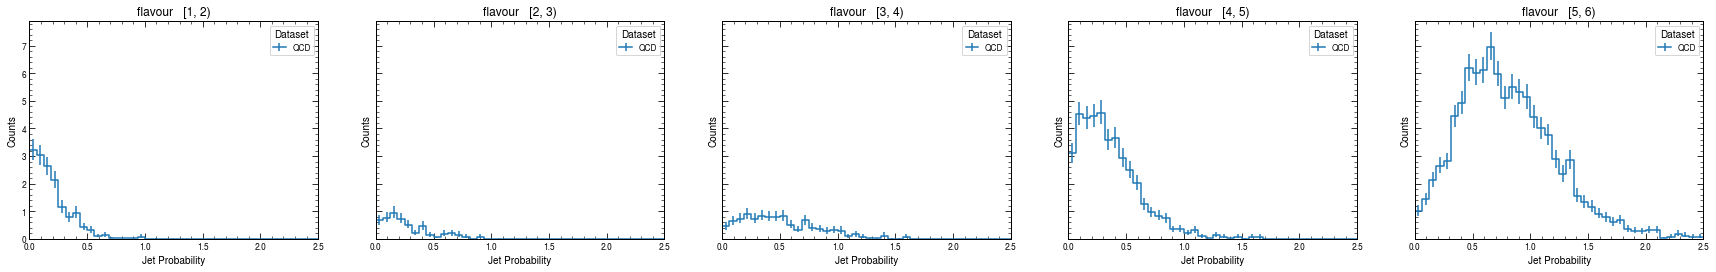

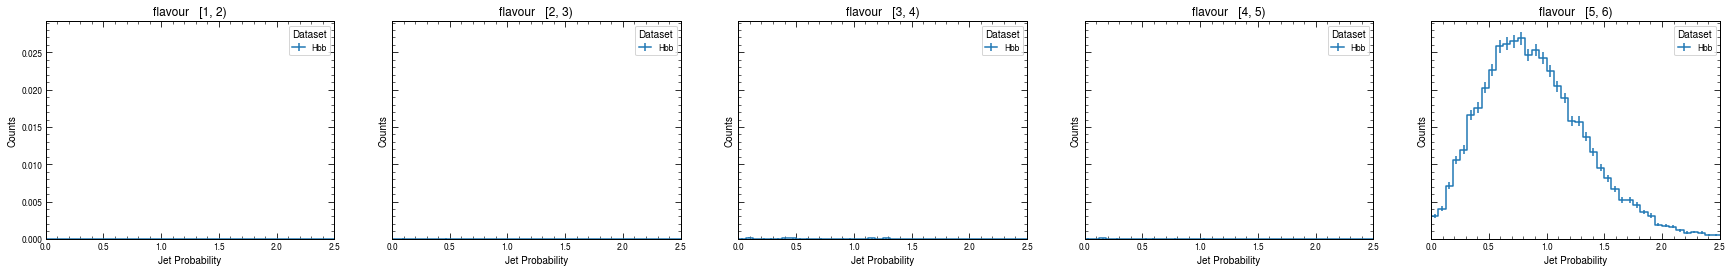

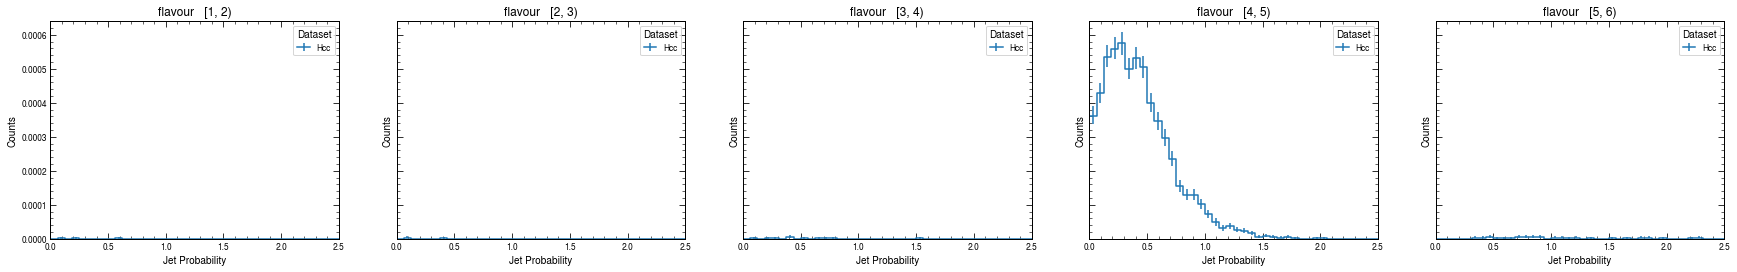

In [19]:
#ig, ax, _ = plot.plot1d(merged['SFJP'].project('ddc').project('dataset', 'QCD', overflow='over').project('nSV'), ax=axs[0], overlay='flav', stack=True)#, density=True)
#fig, ax, _ = plot.plot1d(merged['SFJP'].project('ddc', slice(0.83,1)).project('dataset', 'QCD', overflow='over').project('nSV'), ax=axs[1], overlay='flav', stack=True)#, density=True)

tplt = merged['SFJP'].project('ddc').project('nSV')[['QCD'],:]#.project('dataset', 'QCD', overflow='over')
tplt = tplt.rebin('flav', hist.Bin("flav", r"flavour", [1,2,3,4,5,6]))
plot.plotgrid(tplt,
              figure=None, 
              row=None,
              col='flav', 
              overlay='dataset')

tplt = merged['SFJP'].project('ddc').project('nSV')[['Hbb'],:]#.project('dataset', 'QCD', overflow='over')
tplt = tplt.rebin('flav', hist.Bin("flav", r"flavour", [1,2,3,4,5,6]))
plot.plotgrid(tplt,
              figure=None, 
              row=None,
              col='flav', 
              overlay='dataset')

tplt = merged['SFJP'].project('ddc').project('nSV')[['Hcc'],:]#.project('dataset', 'QCD', overflow='over')
tplt = tplt.rebin('flav', hist.Bin("flav", r"flavour", [1,2,3,4,5,6]))
plot.plotgrid(tplt,
              figure=None, 
              row=None,
              col='flav', 
              overlay='dataset')

(<Figure size 2160x288 with 5 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2ac596a803c8>,
       dtype=object))

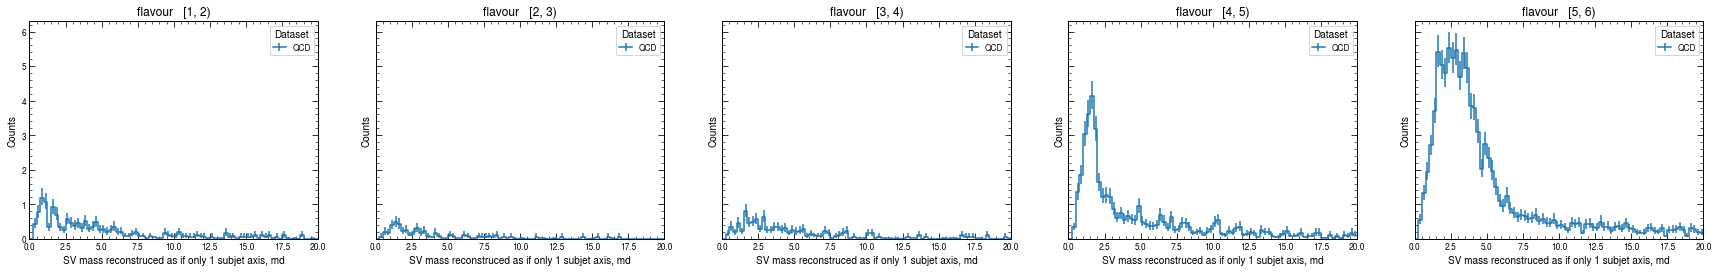

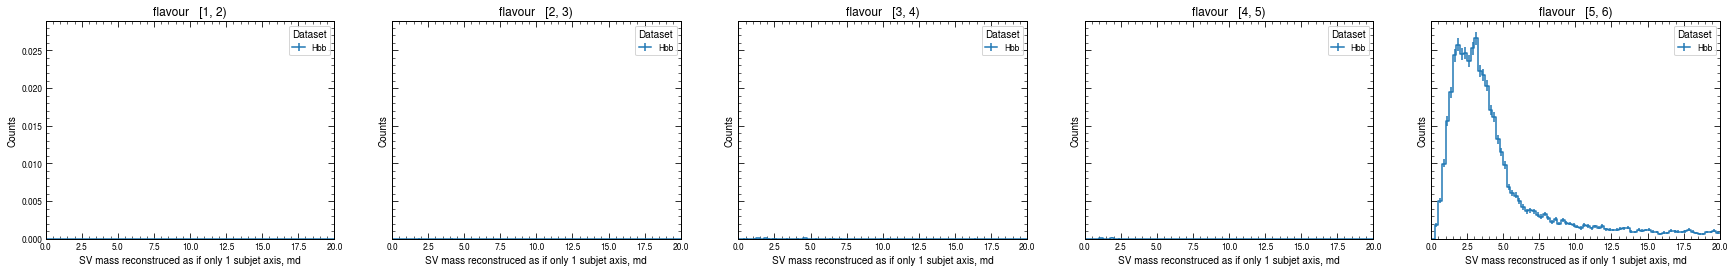

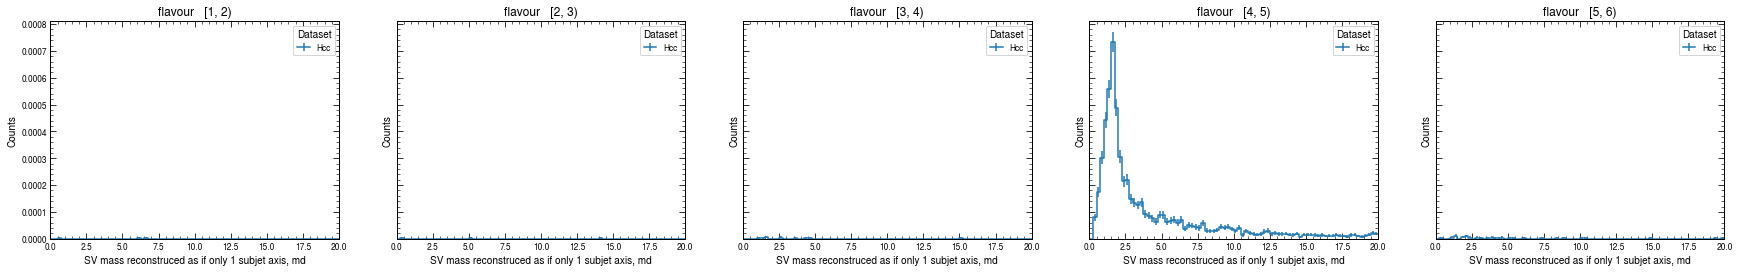

In [20]:
tplt = merged['SFSV'].project('ddc')[['QCD'],:]#.project('JP')#.project('dataset', 'QCD', overflow='over')
tplt = tplt.rebin('flav', hist.Bin("flav", r"flavour", [1,2,3,4,5,6]))
plot.plotgrid(tplt,
              figure=None, 
              row=None,
              col='flav', 
              overlay='dataset')

tplt = merged['SFSV'].project('ddc')[['Hbb'],:]#.project('JP')#.project('dataset', 'QCD', overflow='over')
tplt = tplt.rebin('flav', hist.Bin("flav", r"flavour", [1,2,3,4,5,6]))
plot.plotgrid(tplt,
              figure=None, 
              row=None,
              col='flav', 
              overlay='dataset')

tplt = merged['SFSV'].project('ddc')[['Hcc'],:]#.project('JP')#.project('dataset', 'QCD', overflow='over')
tplt = tplt.rebin('flav', hist.Bin("flav", r"flavour", [1,2,3,4,5,6]))
plot.plotgrid(tplt,
              figure=None, 
              row=None,
              col='flav', 
              overlay='dataset')

tplt = outs['SFJP'].project('ddc').project('nSV')#.project('dataset', 'QCD', overflow='over')
tplt = tplt.rebin('flav', hist.Bin("flav", r"flavour", [1,2,3,4,5,6]))
plot.plotgrid(tplt,
              figure=None, 
              row='dataset',
              col='flav', 
              overlay=None,
              density=True
             )

### To DO
- Plots flavor templates by themselves as a grid
- Add in some cutflow info
- Check flavor definitions
- Implement data/triggers eeek

In [20]:
apply_cuts = [
            'gcc',
            #'1sv_per_sj',
            '1mu_per_sj',
            'tau21_0.3',
            'eta_2.4',
            'm_prun_80',
            'pt_350',
                ]

In [21]:
import matplotlib as mpl
mpl.get_cachedir()

'/home/anovak/.cache/matplotlib'

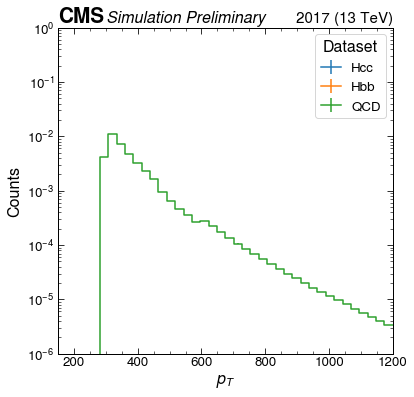

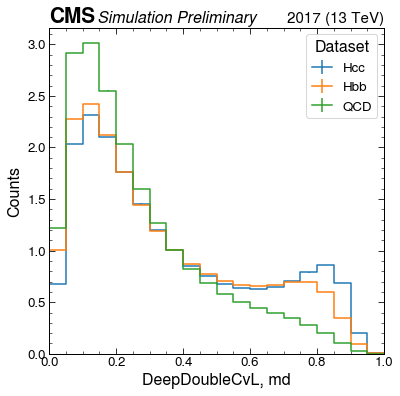

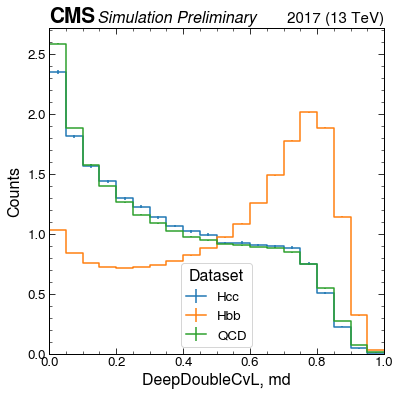

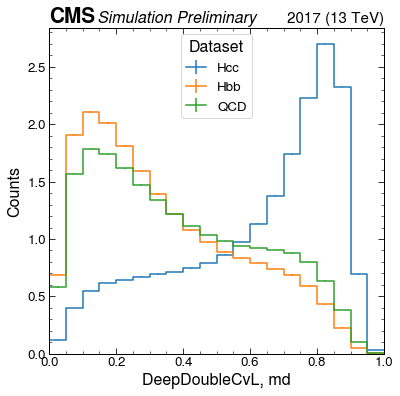

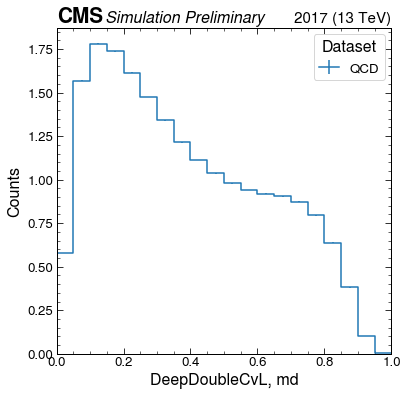

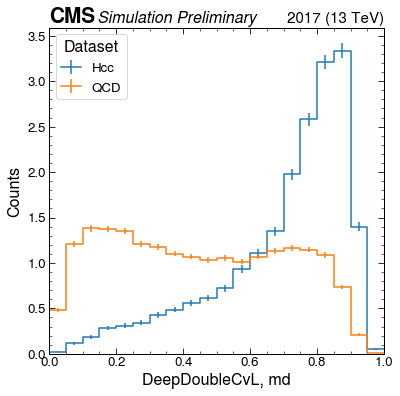

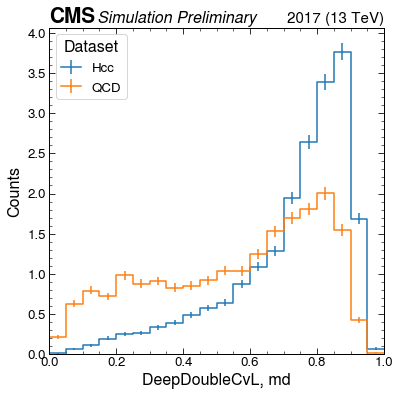

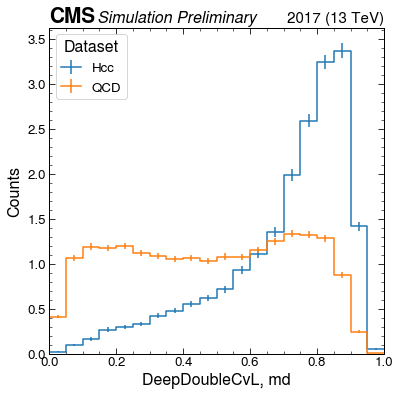

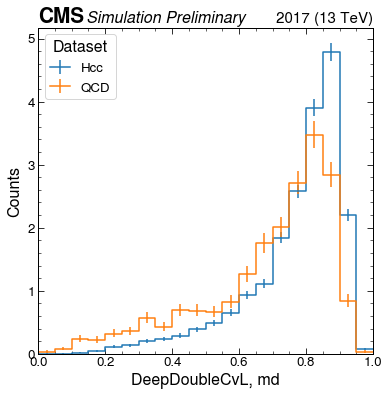

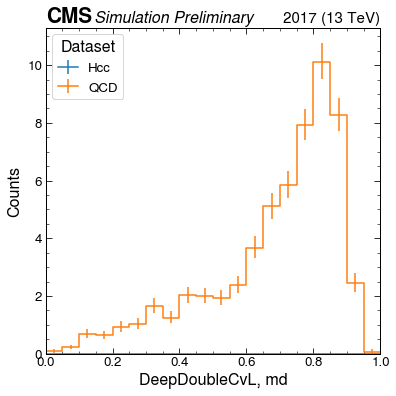

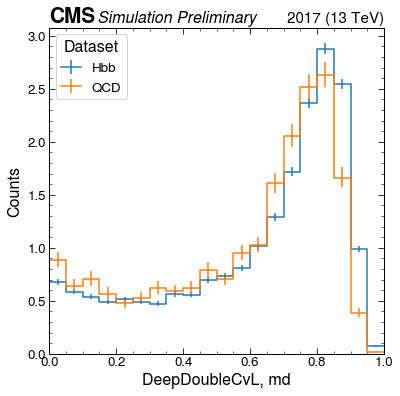

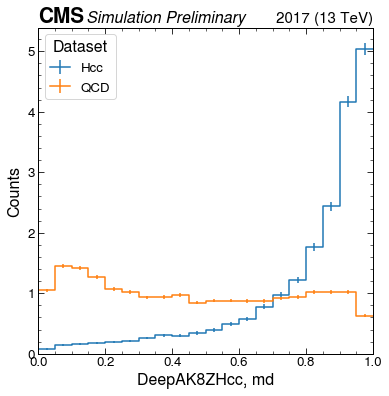

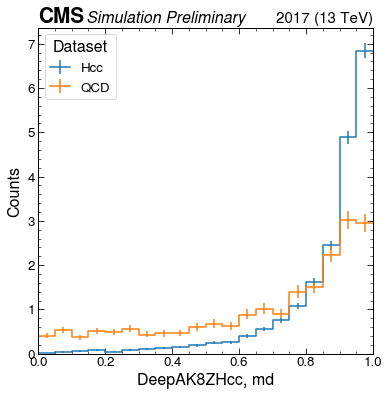

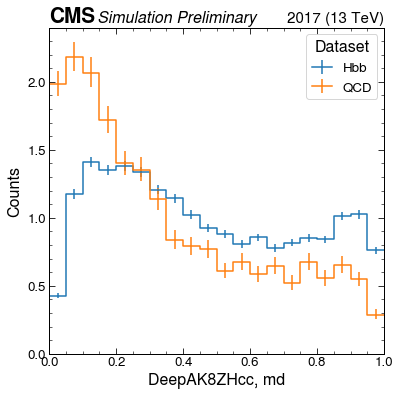

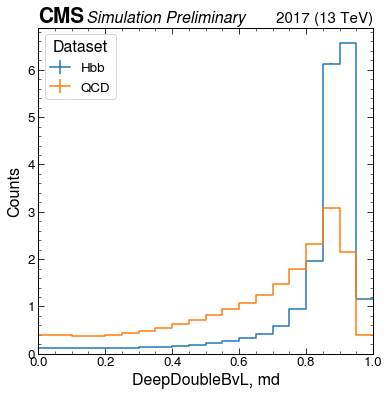

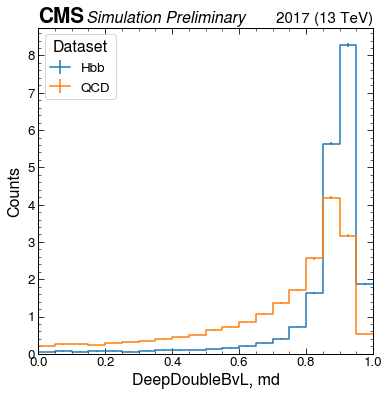

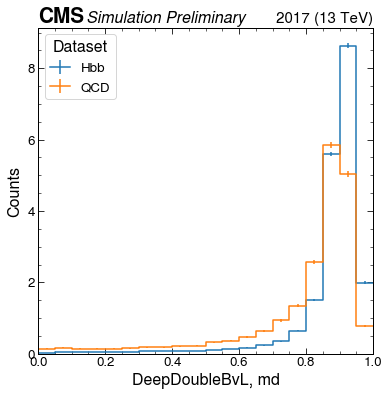

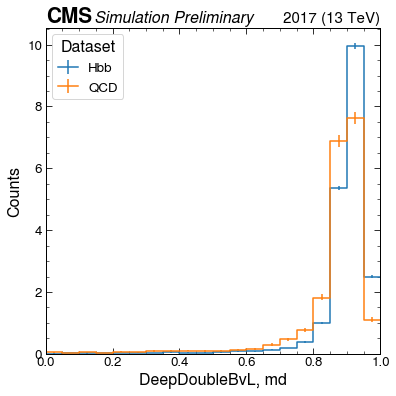

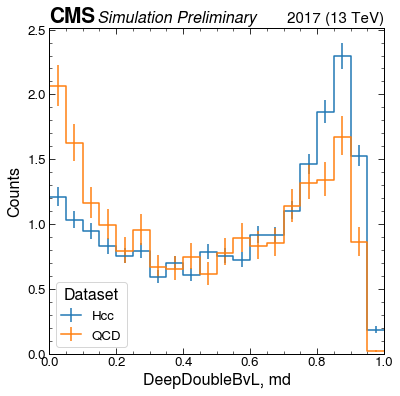

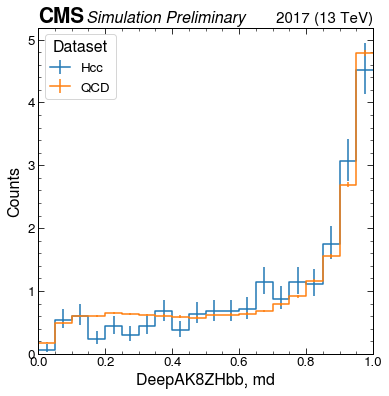

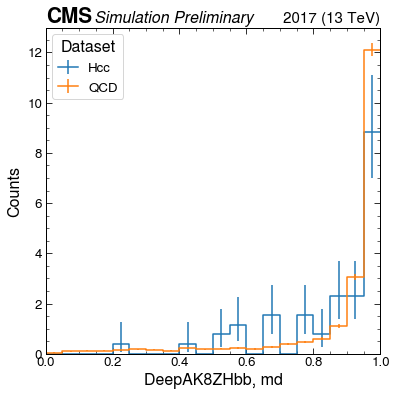

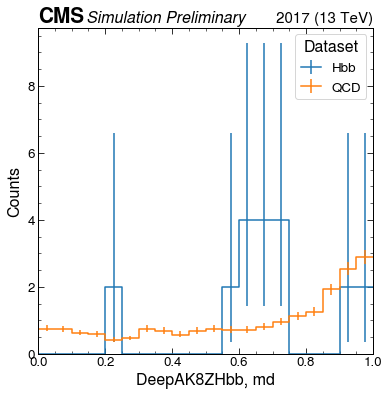

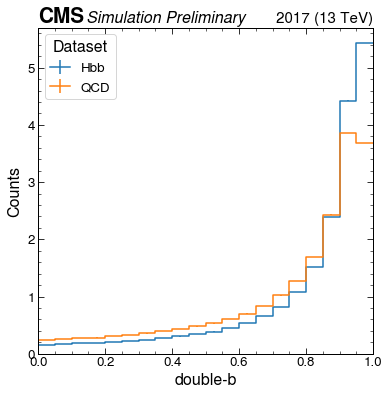

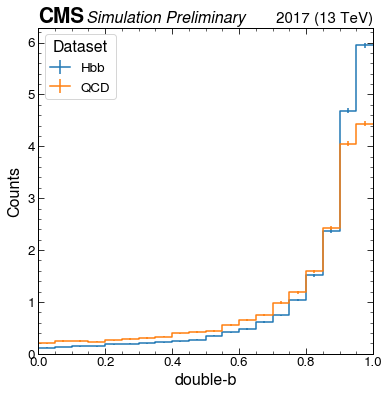

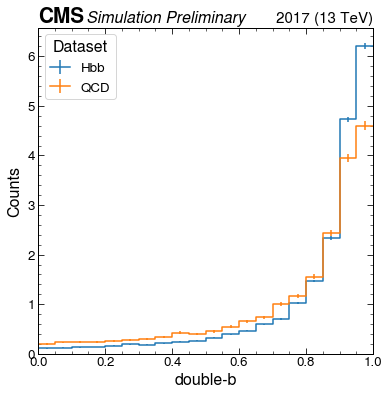

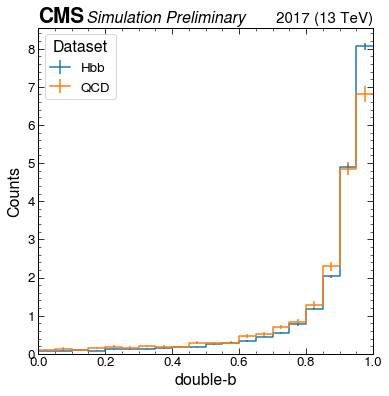

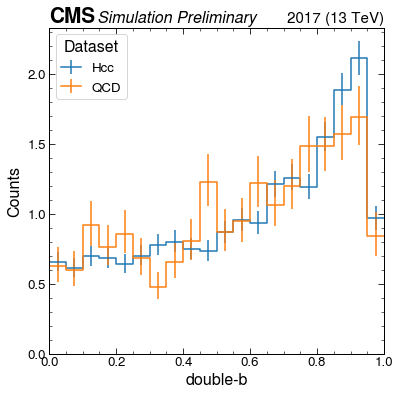

In [26]:
plt.style.use(["ROOTs"])
#fig, ax, _ = plot.plot1d(output['pthat'], overlay='dataset', density=True)
fig, ax, _ = plot.plot1d(merged['pthat'], overlay='dataset', density=True)
ax.set_ylim(0.000001, 1)
ax.semilogy()
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['ddc'].project('flav'), overlay='dataset', density=True)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['ddc'].project('flav',5), overlay='dataset', density=True)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['ddc'].project('flav',4), overlay='dataset', density=True)
ax = cms_annot(ax)

fig, ax, _ = plot.plot1d(merged['ddc'].project('flav',4)[['QCD'], :], overlay='dataset', density=True)
ax = cms_annot(ax)

fig, ax, _ = plot.plot1d(merged['ddc_base'][['QCD',"Hcc"], :].project('flav',4), overlay='dataset', density=True)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['ddc_default'][['QCD',"Hcc"], :].project('flav',4), overlay='dataset', density=True)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['ddc_loose'][['QCD',"Hcc"], :].project('flav',4), overlay='dataset', density=True)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['ddc_mod'][['QCD',"Hcc"], :].project('flav',4), overlay='dataset', density=True)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['ddc_mod'][['QCD',"Hcc"], :].project('flav',4), overlay='dataset', density=False)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['ddc_mod'][['QCD',"Hbb"], :].project('flav',5), overlay='dataset', density=True)
ax = cms_annot(ax)

fig, ax, _ = plot.plot1d(merged['DAK8cc_base'][['QCD',"Hcc"], :].project('flav',4), overlay='dataset', density=True)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['DAK8cc_mod'][['QCD',"Hcc"], :].project('flav',4), overlay='dataset', density=True)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['DAK8cc_mod'][['QCD',"Hbb"], :].project('flav',5), overlay='dataset', density=True)
ax = cms_annot(ax)




fig, ax, _ = plot.plot1d(merged['ddb'][['QCD',"Hbb"], :].project('flav',5), overlay='dataset', density=True)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['ddb_base'][['QCD',"Hbb"], :].project('flav',5), overlay='dataset', density=True)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['ddb_default'][['QCD',"Hbb"], :].project('flav',5), overlay='dataset', density=True)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['ddb_mod'][['QCD',"Hbb"], :].project('flav',5), overlay='dataset', density=True)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['ddb_mod'][['QCD',"Hcc"], :].project('flav',4), overlay='dataset', density=True)
ax = cms_annot(ax)

fig, ax, _ = plot.plot1d(merged['DAK8bb_base'][['QCD',"Hcc"], :].project('flav',5), overlay='dataset', density=True)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['DAK8bb_mod'][['QCD',"Hcc"], :].project('flav',5), overlay='dataset', density=True)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['DAK8bb_mod'][['QCD',"Hbb"], :].project('flav',4), overlay='dataset', density=True)
ax = cms_annot(ax)


fig, ax, _ = plot.plot1d(merged['doubleb'][['QCD',"Hbb"], :].project('flav',5), overlay='dataset', density=True)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['doubleb_base'][['QCD',"Hbb"], :].project('flav',5), overlay='dataset', density=True)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['doubleb_default'][['QCD',"Hbb"], :].project('flav',5), overlay='dataset', density=True)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['doubleb_mod'][['QCD',"Hbb"], :].project('flav',5), overlay='dataset', density=True)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(merged['doubleb_mod'][['QCD',"Hcc"], :].project('flav',4), overlay='dataset', density=True)
ax = cms_annot(ax)


#ax.annotate("Cuts:\n  "+"\n  ".join(apply_cuts), xy=(0.4, 0.95), xycoords='axes fraction', 
#        ha='left', va='top', annotation_clip=False)
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_ylim(20, 600)

In [24]:
merged['ddc_'+mod].project('flav',4).project('dataset', 'ddc')

NameError: name 'mod' is not defined

/home/anovak/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


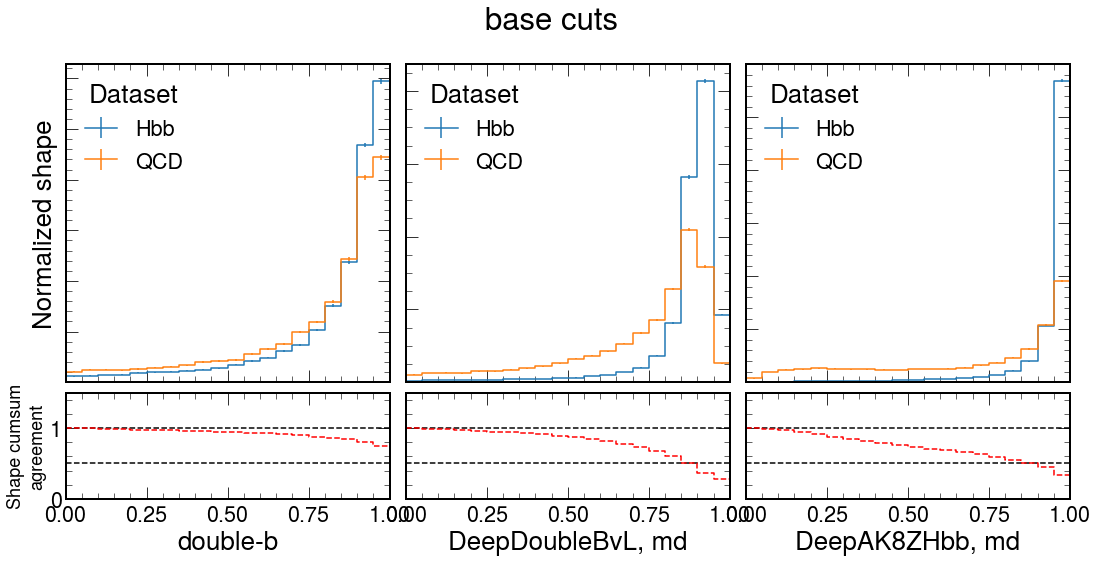

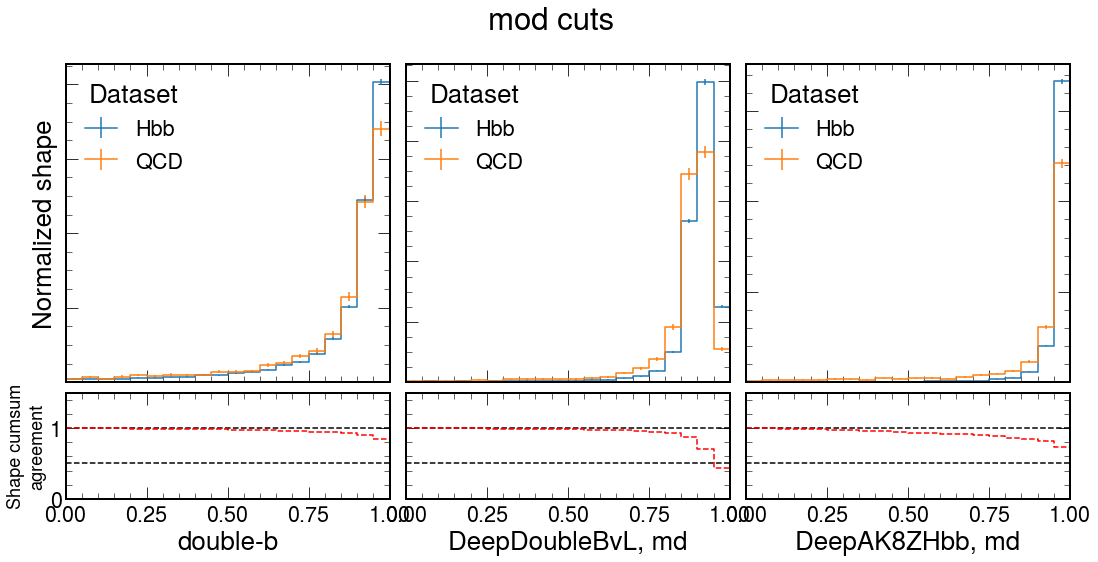

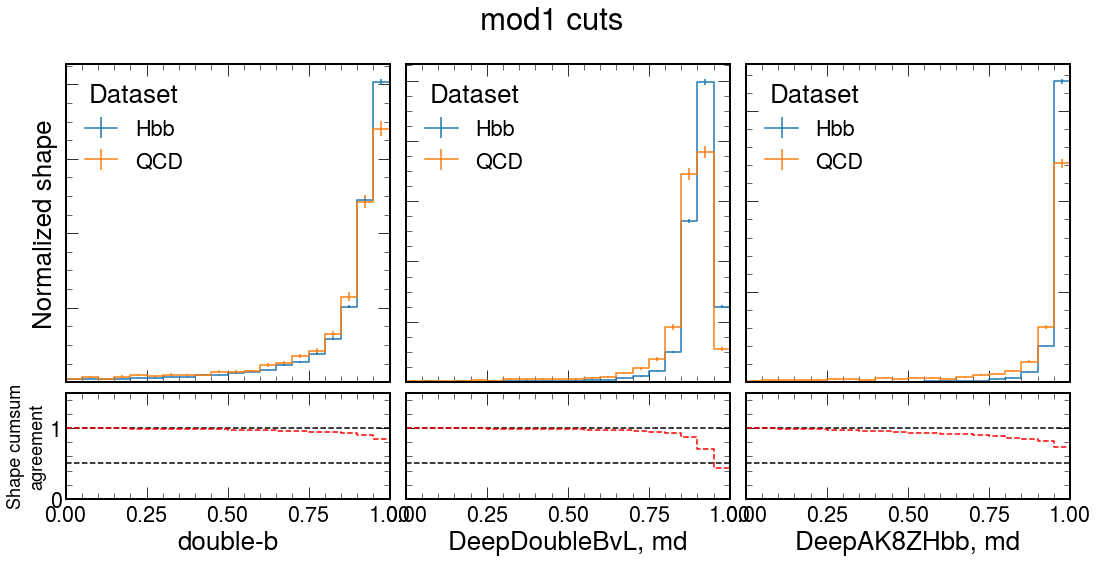

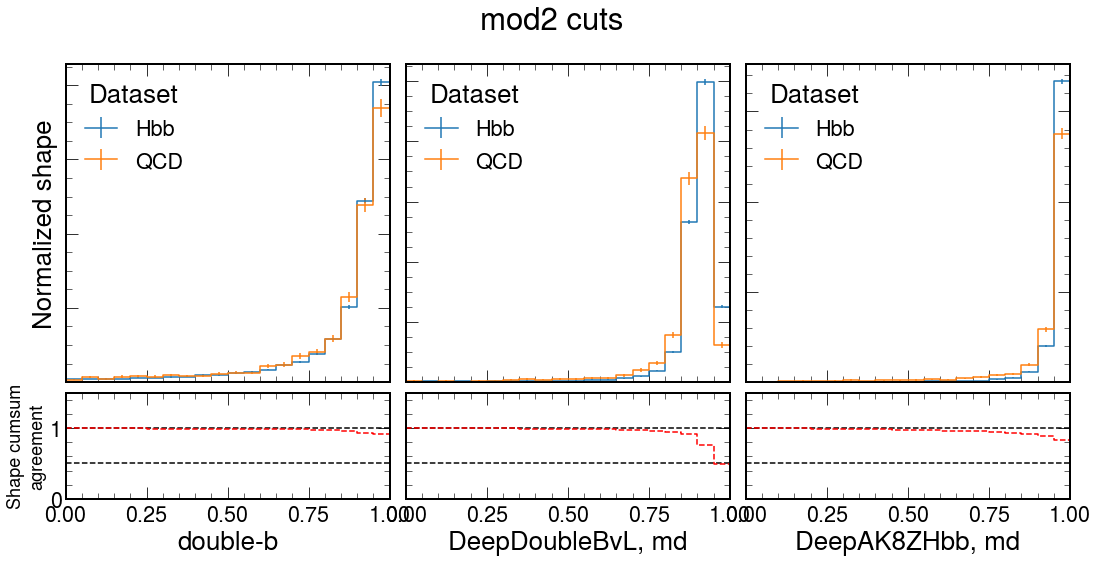

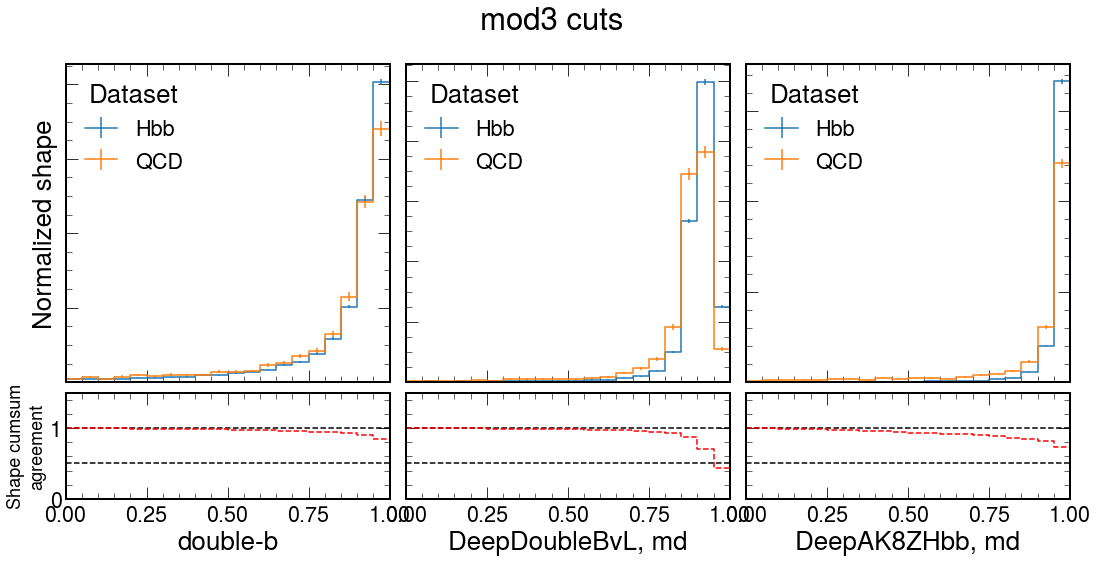

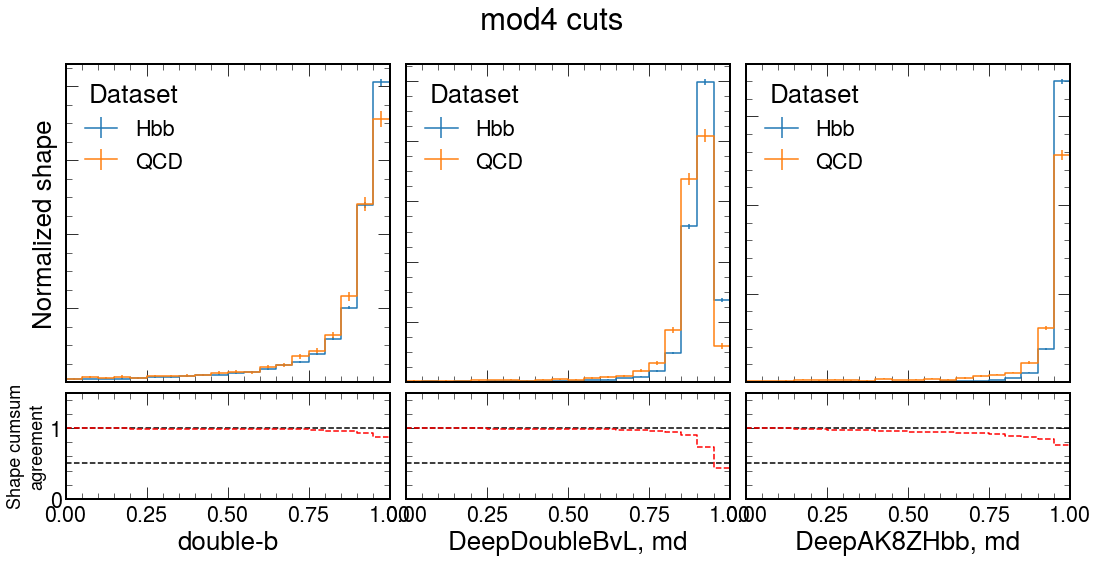

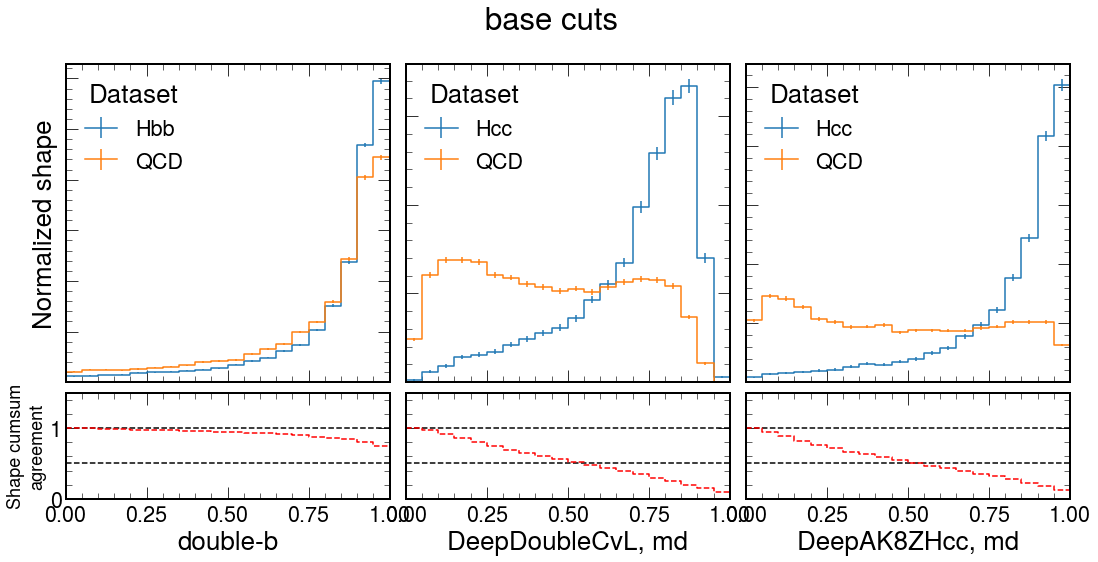

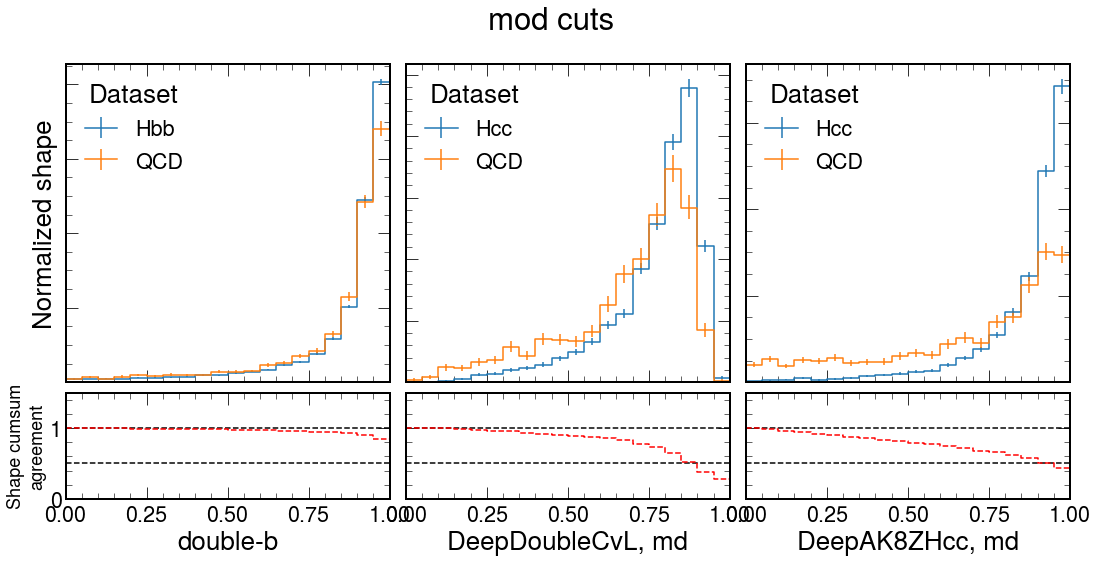

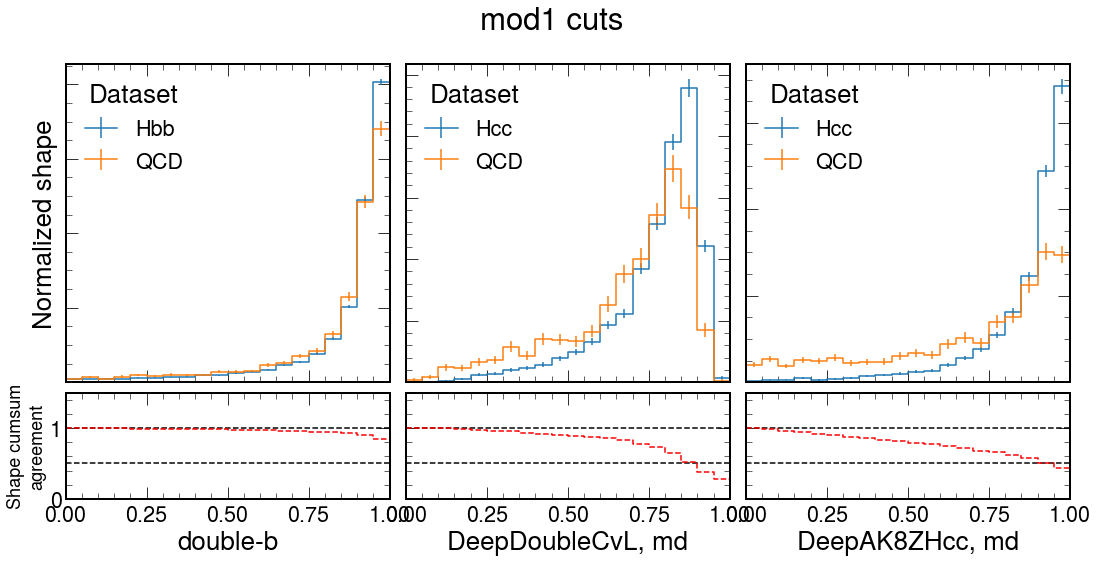

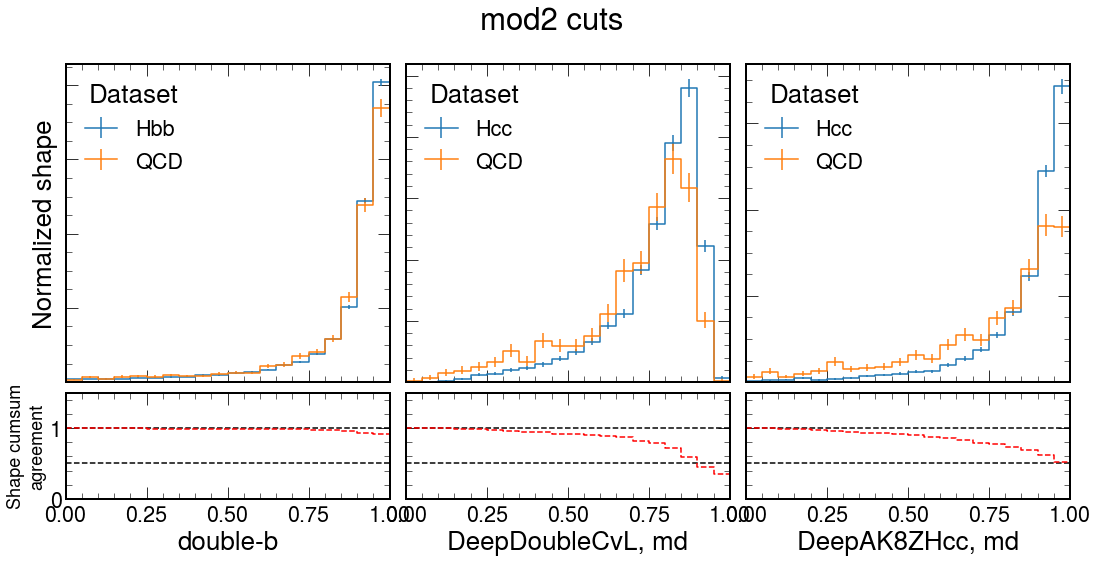

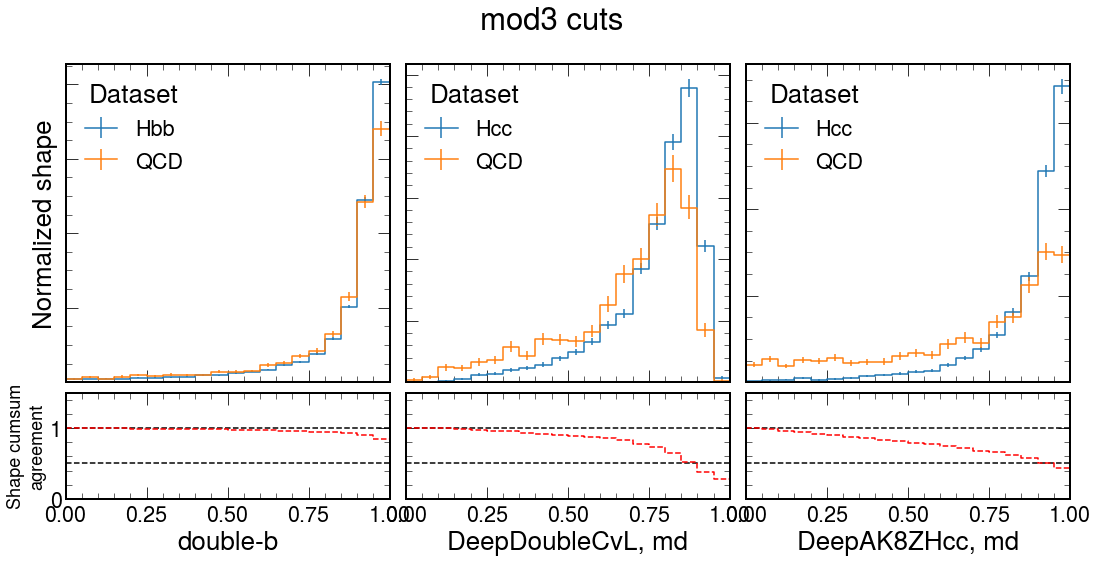

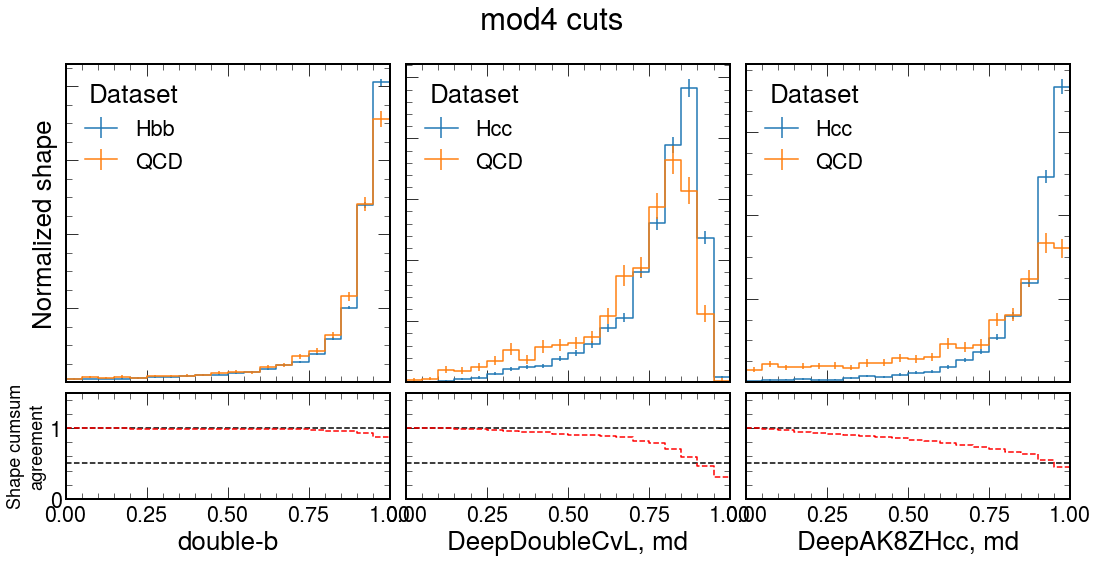

In [18]:
plt.style.use("ROOT")
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
    'emarker': '_'
}


plot_taggers = ['doubleb', 'ddb', 'DAK8bb']

def tagcomp(plot_taggers):
    for mod in ['base','mod' ,'mod1','mod2','mod3', 'mod4']:
        first = True
        fig, axes = plt.subplots(2,len(plot_taggers), gridspec_kw={"height_ratios": (3, 1)}, sharex=True, figsize=(18,8))
        fig.subplots_adjust(hspace=.05)
        fig.subplots_adjust(wspace=.05)
        for tagger, biax in zip(plot_taggers, axes.transpose()):
            ax1, ax2 = biax
            if "c" in tagger:
                fig, ax1, _ = plot.plot1d(merged[tagger+'_'+mod][['QCD','Hcc'], :].project('flav',4), overlay='dataset', density=True, ax=ax1)
                num = merged[tagger+'_'+mod].project('flav',4).project('dataset', 'Hcc')
                denom = merged[tagger+'_'+mod].project('flav',4).project('dataset', 'QCD')
            else:
                fig, ax1, _ = plot.plot1d(merged[tagger+'_'+mod][['QCD','Hbb'], :].project('flav',5), overlay='dataset', density=True, ax=ax1)
                num = merged[tagger+'_'+mod].project('flav',5).project('dataset', 'Hbb')
                denom = merged[tagger+'_'+mod].project('flav',5).project('dataset', 'QCD')
            num.scale(1./num.sum(tagger).values()[()])
            denom.scale(1./denom.sum(tagger).values()[()])
            vnum = num.values()[()]
            vdenom = denom.values()[()]
            a = np.cumsum(vnum[::-1])[::-1]
            b  =np.cumsum(vdenom[::-1])[::-1]
            rbins = b/a
            redges = num.axis(tagger).edges()

            ax2.hlines([1,0.5, 1.5],0,1, linestyle='--')
            ax2.step(redges, np.insert(rbins, -1, rbins[-1]), where='post', c='r', linestyle='--')        

            if first:
                ax2.set_ylabel("Shape cumsum\nagreement", fontsize='x-small')
                ax1.set_ylabel("Normalized shape")
            else:
                ax2.get_yaxis().set_ticklabels([])
                ax1.set_ylabel("")
            ax1.get_yaxis().set_ticklabels([])

            fig.suptitle(mod +' cuts')


            ax2.set_ylim(0,1.5)
            ax2.set_xlabel(ax1.get_xlabel())
            ax1.set_xlabel("")
            ax1.get_legend().set_frame_on(False)


            first = False
    fig.show()
    
tagcomp(plot_taggers)

tagcomp(['doubleb', 'ddc', 'DAK8cc'])

<Hist (ddc,mass) instance at 0x2b0cda9f4160>
<Hist (ddc,mass_prun) instance at 0x2b0cdb44ce48>
<Hist (ddc,pt) instance at 0x2b0cdb55c4e0>
<Hist (ddc,eta) instance at 0x2b0cdb64f048>
<Hist (ddc,tau21) instance at 0x2b0cdb71d550>
<Hist (ddc,nsv) instance at 0x2b0cdb822780>
<Hist (ddc,flav) instance at 0x2b0cdaaf65c0>
<Hist (ddc,doubleb) instance at 0x2b0cda6275c0>
<Hist (ddc,ddb) instance at 0x2b0cd9fb7a58>
<Hist (ddc,DAK8cc) instance at 0x2b0cda730940>
<Hist (ddc,DAK8bb) instance at 0x2b0cda8e2278>
<Hist (ddc,avg_mu_pt) instance at 0x2b0cbe2a0be0>
<Hist (ddc,avg_mu_pt_rat) instance at 0x2b0cdb884b00>
<Hist (ddc,avg_mu_dR) instance at 0x2b0cdaaa46a0>
<Hist (ddc,JP) instance at 0x2b0cdab06208>
<Hist (ddc,SVmass) instance at 0x2b0cda807630>
<Hist (ddc,nSV) instance at 0x2b0cda795940>


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


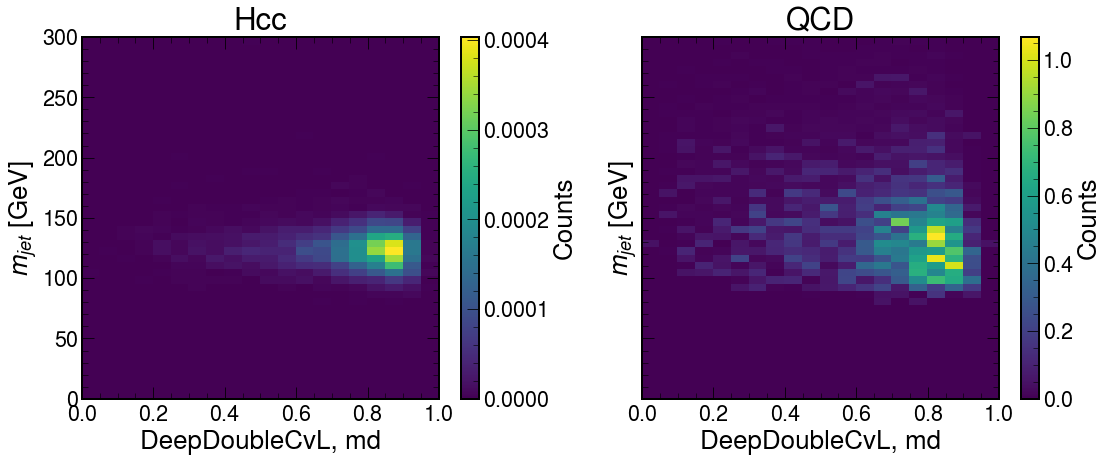

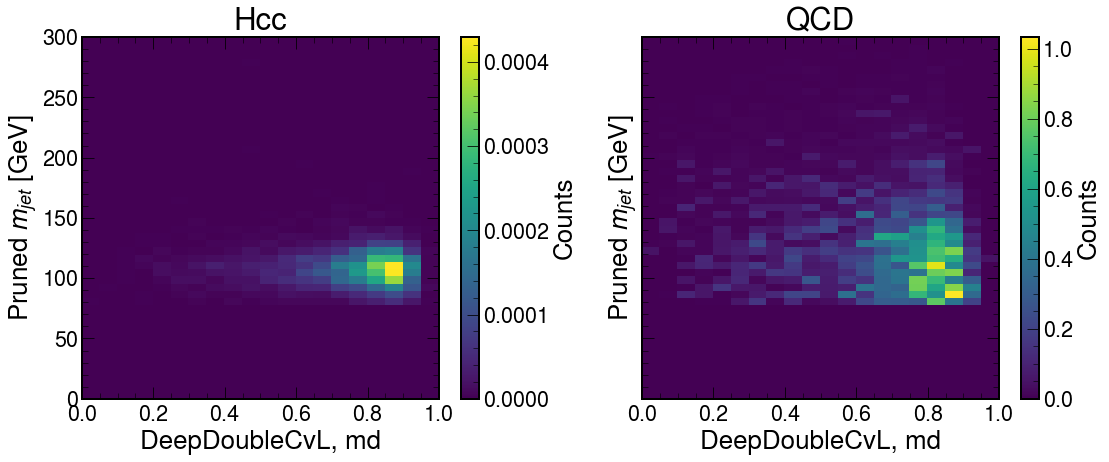

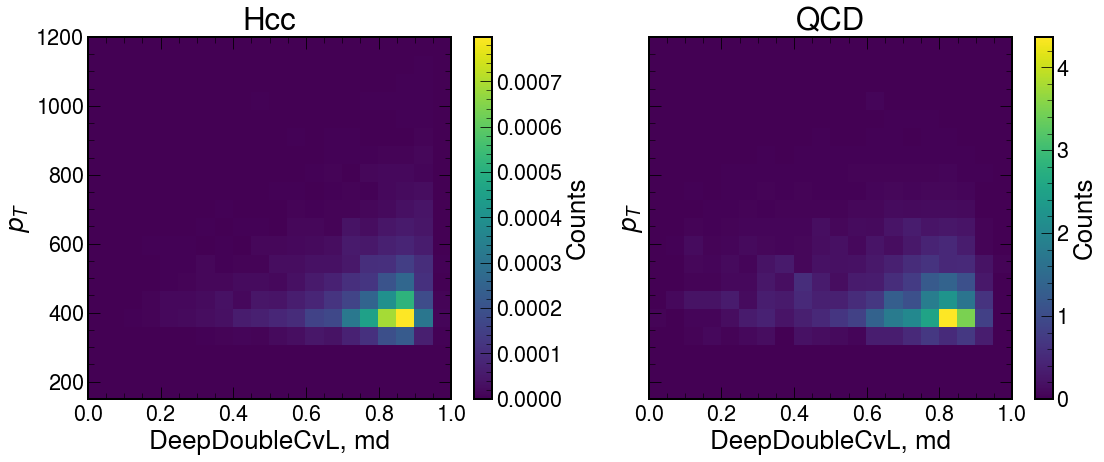

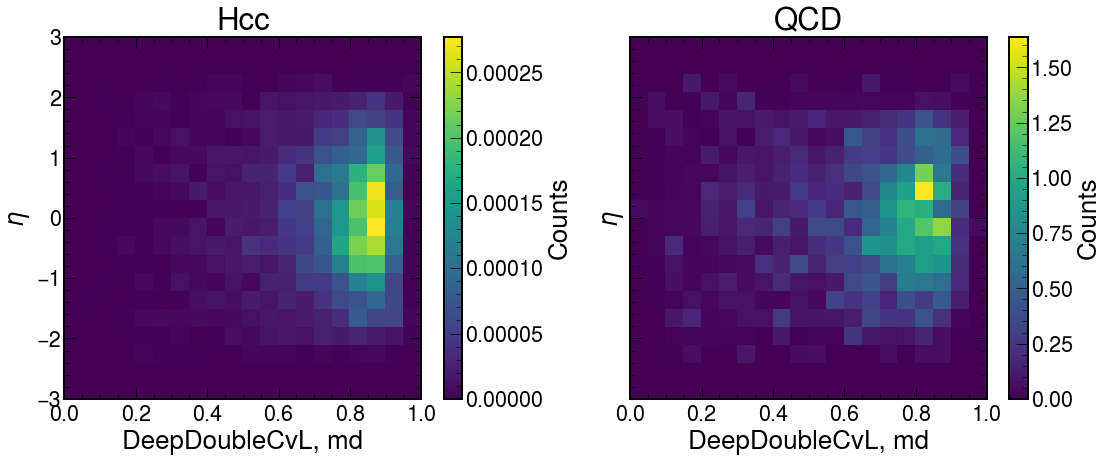

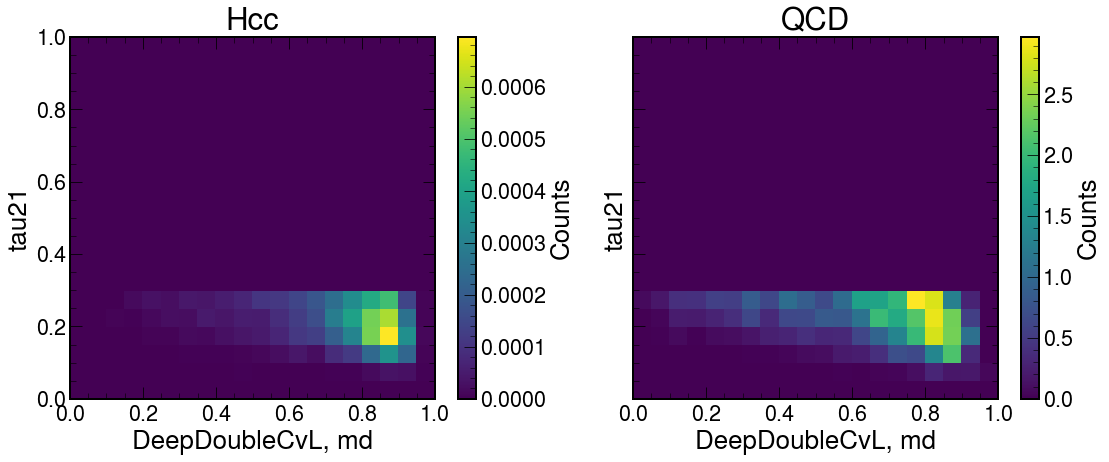

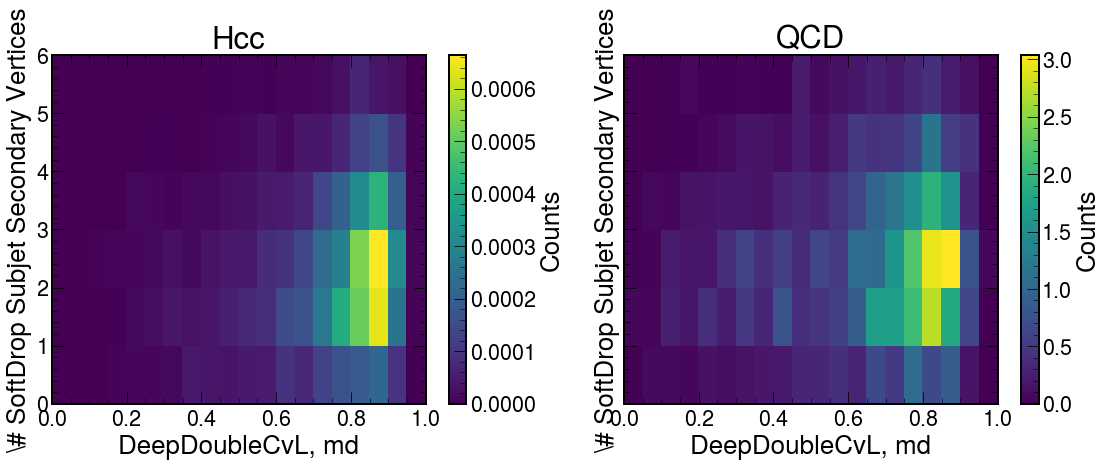

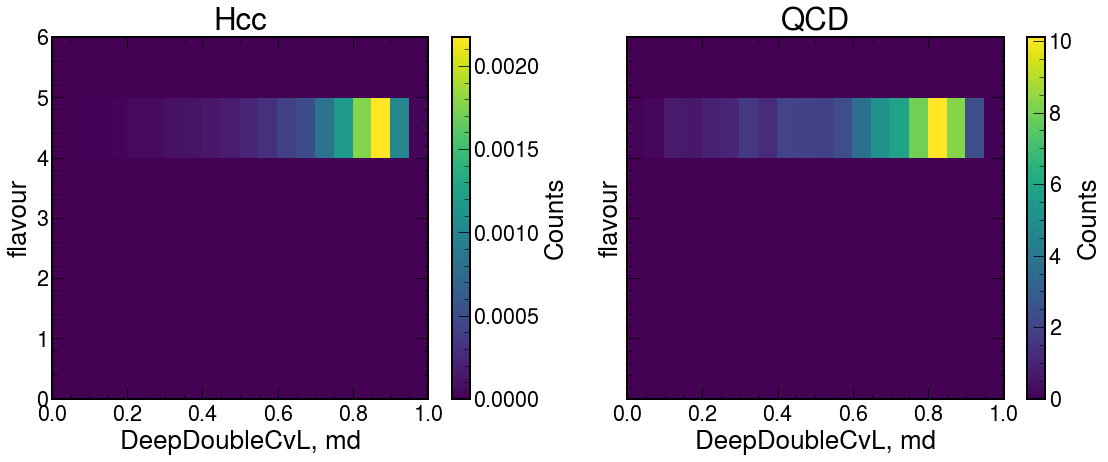

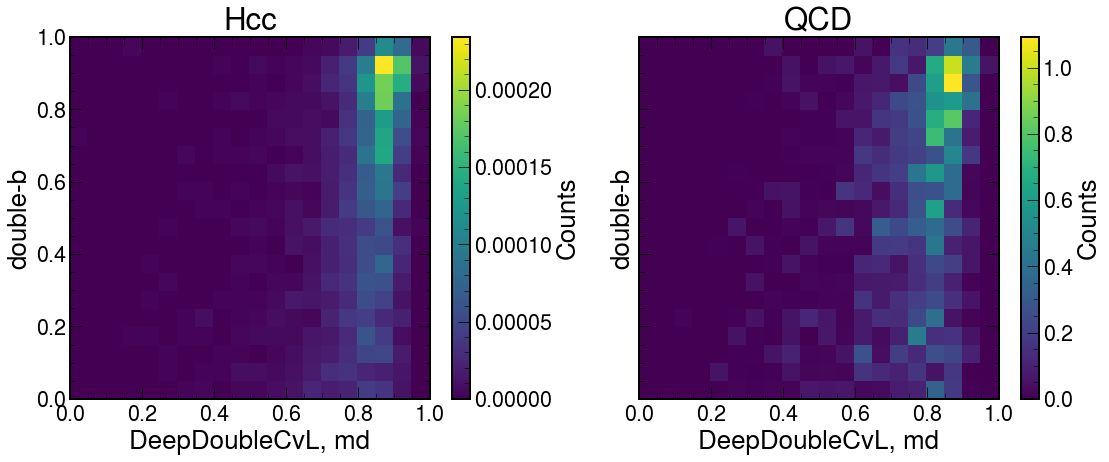

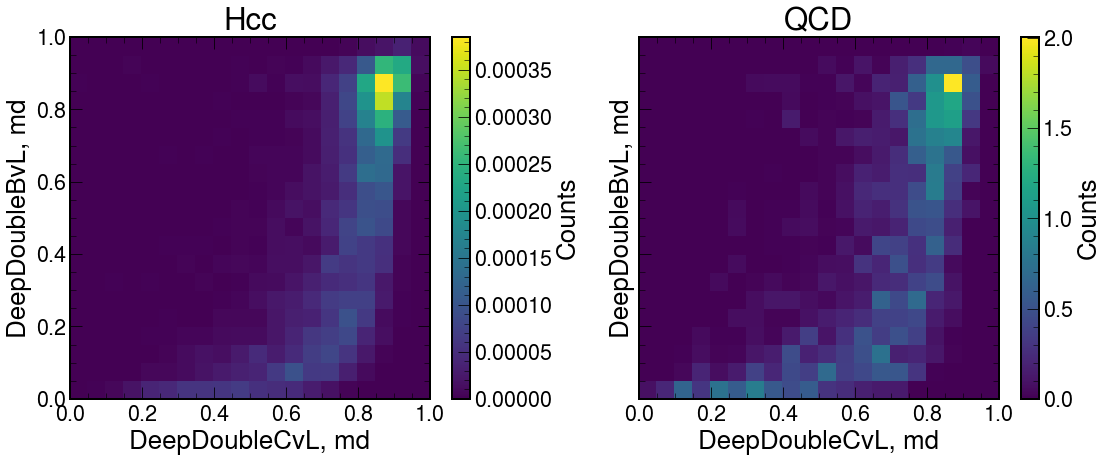

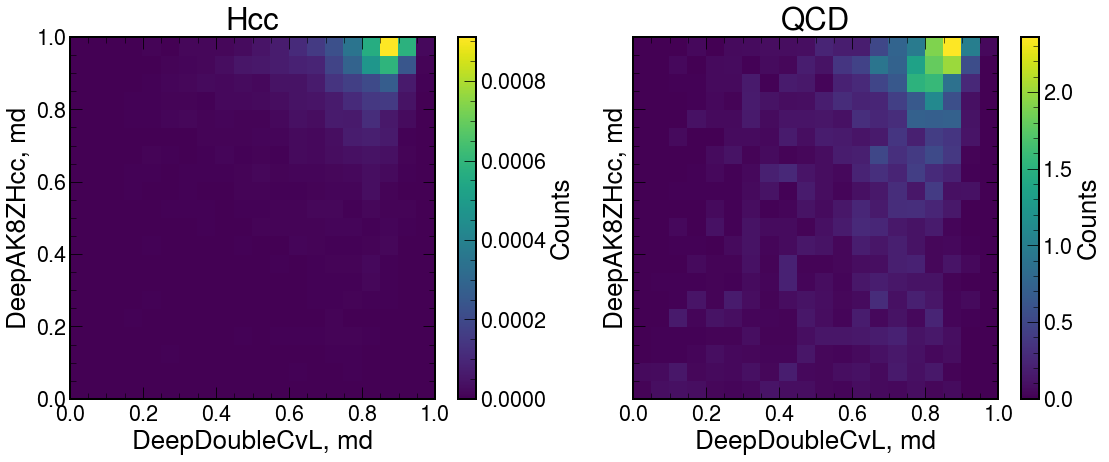

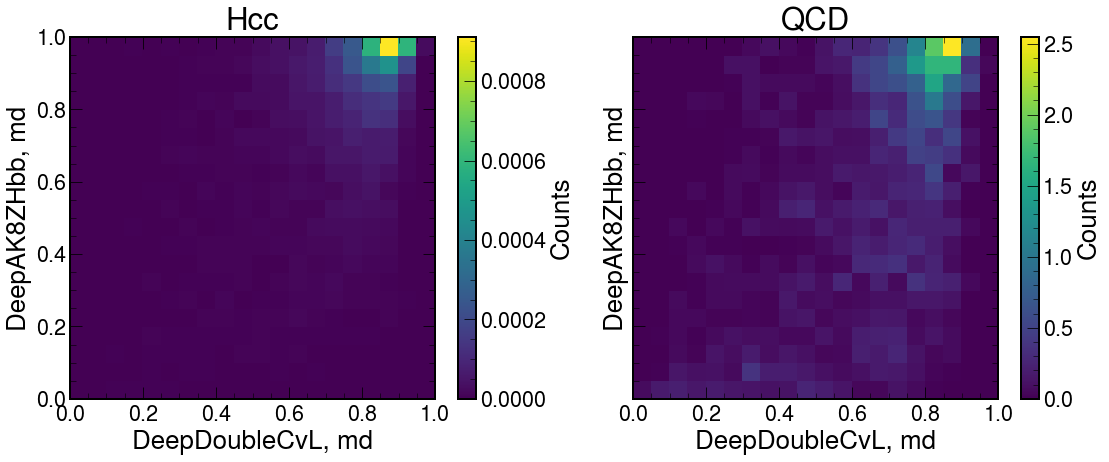

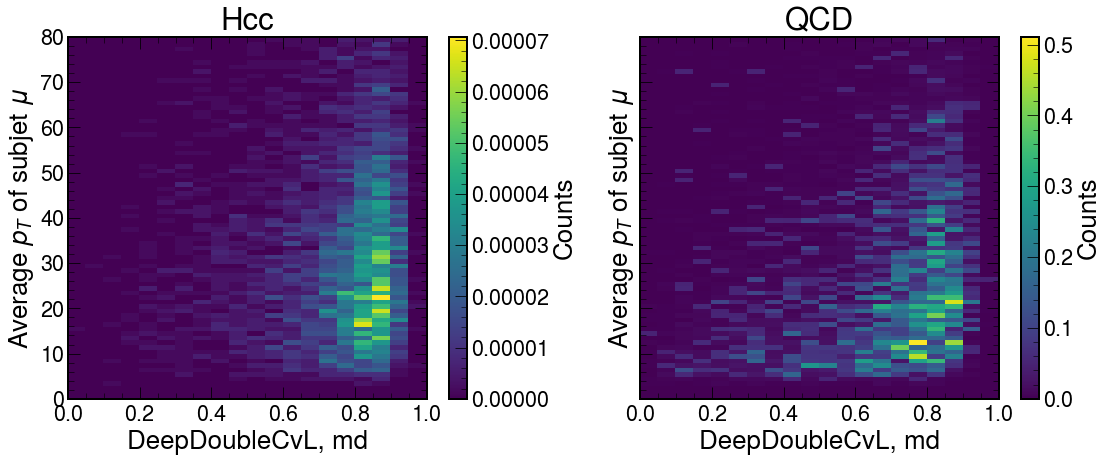

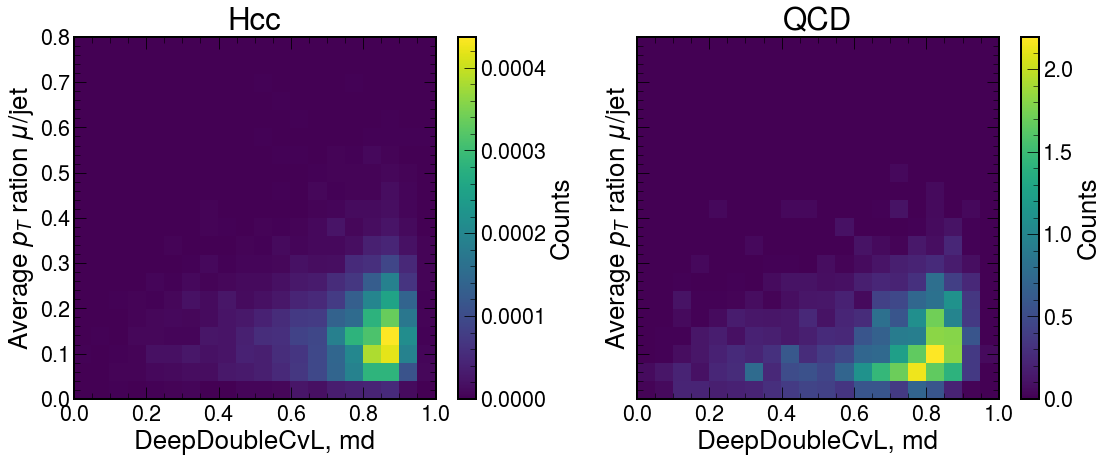

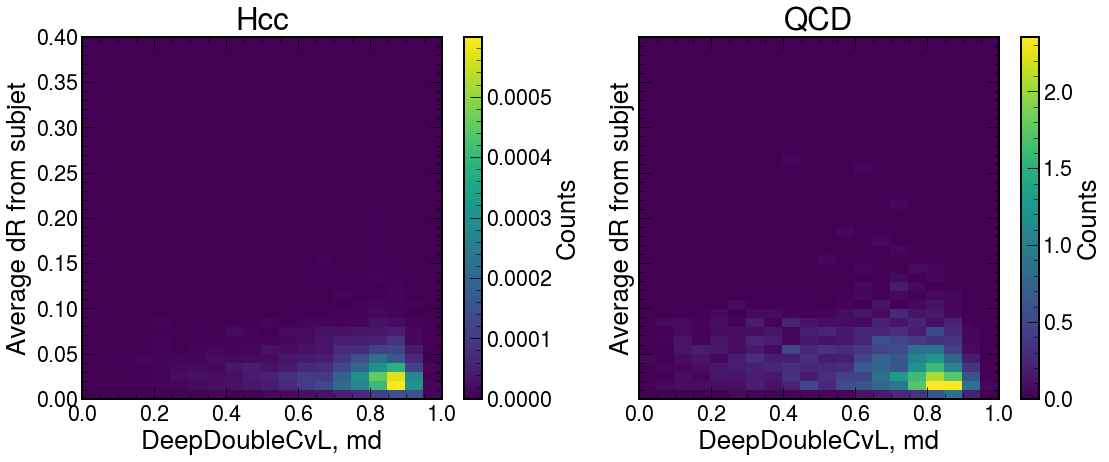

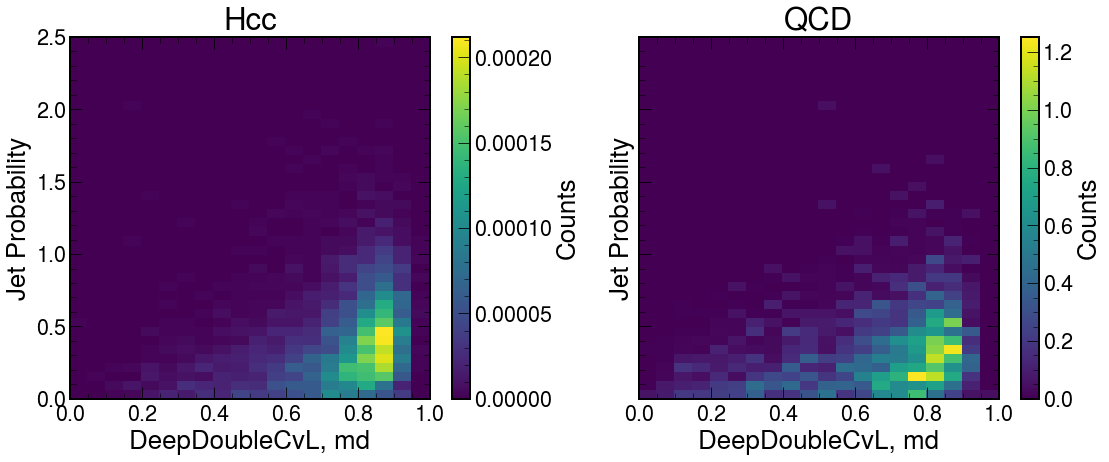

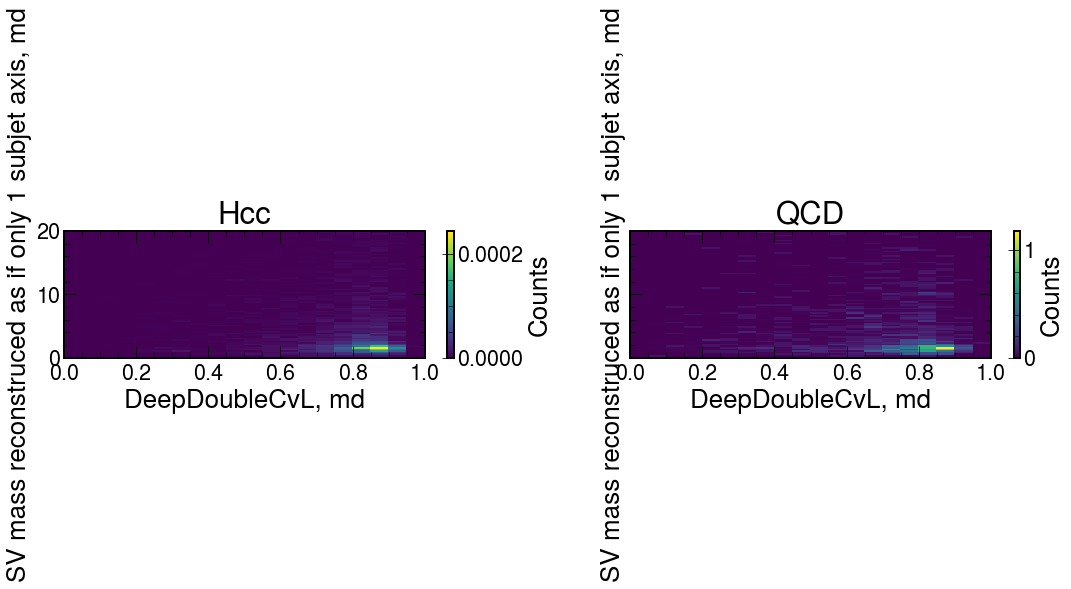

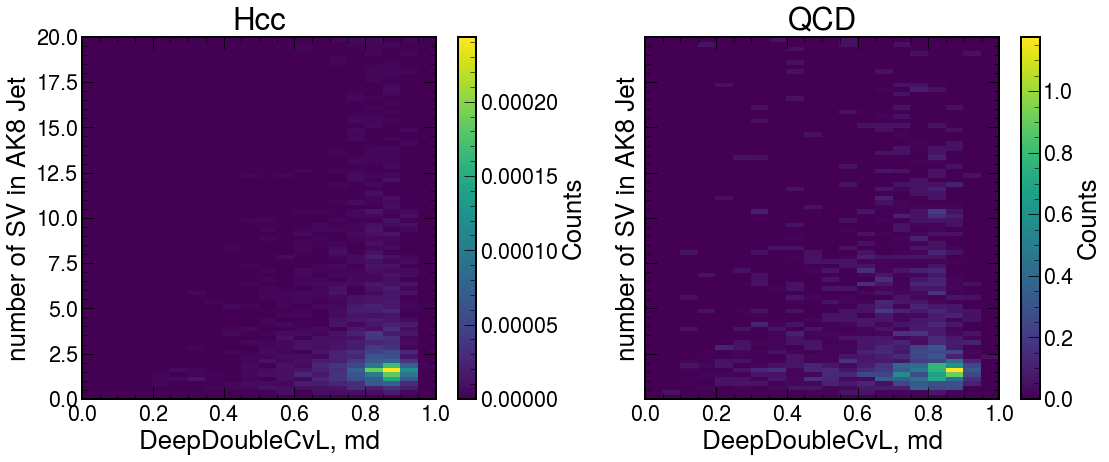

In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#from fnal_column_analysis_tools.hist import plot

def compare(Hist, xaxis='ddc'):
    try:
        _test = Hist.project('dataset', "QCD", overflow='over')
        print(_test)
    except:
        print('Not a histogram')
        return
    ncat = Hist.axis('dataset').size -1
    fig, axs = plt.subplots(1, ncat, figsize=(16,7), sharex=True, sharey=True, tight_layout=True)
    cats = [cat for cat in Hist.axis('dataset').identifiers() if "Hbb" not in str(cat)]
    for cat, ax in zip(cats, axs):
        fig, ax, _ = plot.plot2d(Hist.project('dataset', cat, overflow='over'), 
                                 #log=True,
                                 xaxis=xaxis, ax=ax)
        ax.set_title(cat)
        #ax.zaxis.set_scale('log')
        #print(ax.get_children() )

    
for k in JetProcessor().axes.keys():
    if k == 'ddc': continue
    compare(merged['looseddc_'+k])

In [ ]:
for k in JetProcessor().axes.keys():
    if k == 'doubleb': continue
    compare(output['cutdb_'+k], xaxis='doubleb')

In [39]:
funbtup['btaganaFatJets'].keys()

[b'HistJets;1', b'HistSoftDropPuppiSubJets;1', b'ttree;25', b'ttree;24']